# Performance tests of STRUMPACK using OpenMP and MPI on Cori

We make use of the linear solver backends within cctbx.xfel, and evaluate their performance on a variety of sample A matrices and b vectors for 1k, 5k, 10k, and 32k images each, and for a variety of different refinement parameters. The time to solve a single sparse system will offer insight into the time spent during the Levenberg-Marquardt minimisation process.

For these tests we use EIGEN with the following solver algorithms:

$$
\textrm{EIGEN} = \left\{\begin{matrix}
\textrm{SimplicialLLT} \\ 
\textrm{SimplicialLDLT} \\ 
\textrm{ConjugateGradient}\\
\textrm{BiCGSTAB}
\end{matrix}\right\}
$$


Additionally, we test against the solvers from STRUMPACK using both the OpenMP and MPI enabled backends. For the single-node (OpenMP) tests, the solvers and reordering methods are:


$$
\textrm{OpenMP STRUMPACK} = 
\left\{
\begin{matrix}
 \textrm{METIS} & \textrm{AUTO} \\
 \textrm{METIS} & \textrm{BiCGSTAB} \\
 \textrm{METIS} & \textrm{PREC_BICGSTAB} \\
 \hline
 \textrm{SCOTCH} & \textrm{AUTO} \\
 \textrm{SCOTCH} & \textrm{BiCGSTAB} \\
 \textrm{SCOTCH} & \textrm{PREC_BICGSTAB}
\end{matrix}
\right\}
$$


For the MPI tests, we can use the parallel versions of the reordering methods, and choose from a variety of solvers as:

$$
\textrm{MPI STRUMPACK} = 
\left\{
\begin{matrix}
 \textrm{PARMETIS} & \textrm{AUTO} \\
 \textrm{PARMETIS} & \textrm{DIRECT} \\
 \textrm{PARMETIS} & \textrm{PREC_BICGSTAB} \\
 \textrm{PARMETIS} & \textrm{REFINE} \\
 \textrm{PARMETIS} & \textrm{PREC_GMRES} \\
 \textrm{PARMETIS} & \textrm{GMRES} \\
 \textrm{PARMETIS} & \textrm{PREC_BICGSTAB} \\
 \textrm{PARMETIS} & \textrm{BICGSTAB} \\
 \hline
 \textrm{PTSCOTCH} & \textrm{AUTO} \\
 \textrm{PTSCOTCH} & \textrm{DIRECT} \\
 \textrm{PTSCOTCH} & \textrm{PREC_BICGSTAB} \\
 \textrm{PTSCOTCH} & \textrm{REFINE} \\
 \textrm{PTSCOTCH} & \textrm{PREC_GMRES} \\
 \textrm{PTSCOTCH} & \textrm{GMRES} \\
 \textrm{PTSCOTCH} & \textrm{PREC_BICGSTAB} \\
 \textrm{PTSCOTCH} & \textrm{BICGSTAB} \
\end{matrix}
\right\}
$$


For this notebook we will enable the STRUMPACK-enabled conda backend, built following the instructions [here](https://github.com/ExaFEL/exafel_project/tree/master/95-strumpack_cctbx) and setting the Jupyter kernel following [these instructions](https://github.com/ExaFEL/exafel_project/tree/master/jupyter). We also perform job submission using the SlurmMagics Python package, allow direct submission to the Cori queueing system. Additionally, we may also dynamically generate submission scripts, and plot the results upon completion. We begin by verifying the environment is correctly built and set up:


In [1]:
!which libtbx.python

/global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/build/bin/libtbx.python


In [2]:
from slurm_magic import SlurmMagics
ip = get_ipython()
ip.register_magics(SlurmMagics)

In [4]:
%squeue -u mlxd

Empty DataFrame
Columns: [JOBID, PARTITION, NAME, USER, ST, TIME, NODES, NODELIST(REASON)]
Index: []

# OpenMP solver performance on Haswell

In [5]:
OMP_SOLVER='''
from __future__ import division
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler
import sys
import numpy as np
import scipy.sparse as sps

A_path=sys.argv[1]
A_mat = np.loadtxt(A_path,dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})

b_path=sys.argv[2] 
b_vec = np.loadtxt(b_path)

n_rows = len(b_vec)
n_cols = n_rows

A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols'])))

#Check for triangular matrix. If so, A_sp := A+A^T - diag(A)

tu=sps.triu(A_sp)
tl=sps.tril(A_sp)
sd=sps.diags(A_sp.diagonal())

A_spS = A_sp
if tu.nnz == sd.getnnz() or tl.nnz == sd.getnnz():
    A_spS = A_sp + A_sp.transpose() - sd

A_indptr = flex.int(A_sp.indptr)
A_indices = flex.int(A_sp.indices)
A_values = flex.double(A_sp.data)
b = flex.double(b_vec)

#import time
#timing_dict = {"strum":0, "eigen":0}

import boost.python
ext_omp = boost.python.import_ext("scitbx_examples_strumpack_solver_ext")
ext_mpi = boost.python.import_ext("scitbx_examples_strumpack_mpi_dist_solver_ext")

es   = ext_omp.eigen_solver
ss   = ext_omp.strumpack_solver

eps_tol = 1e-3

def run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b, A_spS):

    P = Profiler("EIGEN_LLT_CHOL")
    res_eig_llt_chol = es(0, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    
    P = Profiler("EIGEN_LDLT_CHOL")
    res_eig_ldlt_chol = es(1, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    
    A_indptr = flex.int(A_spS.indptr)
    A_indices = flex.int(A_spS.indices)
    A_values = flex.double(A_spS.data)
    
    #Seems to fail for certain data sets.
    #P = Profiler("EIGEN_BICGSTAB")
    #res_eig_bicgstab = es(2, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    #del P
    
    P = Profiler("EIGEN_CG")
    res_eig_cg = es(3, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    
    P = Profiler("STRUMPACK_SCOTCH_AUTO")
    res_strum_sc_a = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.scotch, ext_omp.auto)
    del P
    
    P = Profiler("STRUMPACK_METIS_AUTO")
    res_strum_mt_a = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.metis, ext_omp.auto)
    del P

    P = Profiler("STRUMPACK_SCOTCH_BICGSTAB")
    res_strum_sc_bi = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.scotch, ext_omp.bicgstab)
    del P
    
    P = Profiler("STRUMPACK_METIS_BICGSTAB")
    res_strum_mt_bi = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.metis, ext_omp.bicgstab)
    del P
    
    P = Profiler("STRUMPACK_SCOTCH_PRECBICGSTAB")
    res_strum_sc_pr = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.scotch, ext_omp.prec_bicgstab)
    del P
    
    P = Profiler("STRUMPACK_METIS_PRECBICGSTAB")
    res_strum_mt_pr = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.metis, ext_omp.prec_bicgstab)
    del P
    num_errors = 0
    err_names = {}
    for i in xrange(len(res_strum_sc_a.x)):
        if not approx_equal(res_eig_llt_chol.x[i], res_eig_ldlt_chol.x[i], eps=eps_tol): 
            num_errors += 1
            print "Error in res_eig_llt_chol:=%f != res_eig_ldlt_chol:=%f @ [%d] "%(res_eig_llt_chol.x[i], res_eig_ldlt_chol.x[i],i)
            
        #if not approx_equal(res_strum_sc_a.x[i], res_eig_bicgstab.x[i], eps=eps_tol):
        #    num_errors += 1
        #    print "Error in res_strum_sc_a:=%f != res_eig_bicgstab:=%f @ [%d] "%(res_strum_sc_a.x[i], res_eig_bicgstab.x[i],i)
            
        if not approx_equal(res_strum_sc_a.x[i], res_eig_cg.x[i], eps=eps_tol):
            num_errors += 1
            print "Error in res_strum_sc_a:=%f != res_eig_cg:=%f @ [%d] "%(res_strum_sc_a.x[i], res_eig_cg.x[i],i)

        if not approx_equal(res_strum_sc_a.x[i], res_eig_ldlt_chol.x[i], eps=eps_tol):
            num_errors += 1
            print "Error in res_strum_sc_a:=%f != res_eig_ldlt_chol:=%f @ [%d] "%(res_strum_sc_a.x[i], res_eig_ldlt_chol.x[i],i)

        if not approx_equal(res_strum_mt_a.x[i], res_strum_sc_a.x[i], eps=eps_tol):
            num_errors += 1
            print "Error in res_strum_mt_a:=%f != res_strum_sc_a:=%f @ [%d] "%(res_strum_mt_a.x[i], res_strum_sc_a.x[i],i)

        if not approx_equal(res_strum_mt_a.x[i], res_strum_sc_bi.x[i], eps=eps_tol):
            num_errors += 1
            print "Error in res_strum_mt_a:=%f != res_strum_sc_bi:=%f @ [%d] "%(res_strum_mt_a.x[i], res_strum_sc_bi.x[i],i)

        if not approx_equal(res_strum_mt_a.x[i], res_strum_mt_bi.x[i], eps=eps_tol):
            num_errors += 1
            print "Error in res_strum_mt_a:=%f != res_strum_mt_bi:=%f @ [%d] "%(res_strum_mt_a.x[i], res_strum_mt_bi.x[i],i)

        if not approx_equal(res_strum_mt_a.x[i], res_strum_sc_pr.x[i], eps=eps_tol):
            num_errors += 1
            print "Error in res_strum_mt_a:=%f != res_strum_sc_pr:=%f @ [%d] "%(res_strum_mt_a.x[i], res_strum_sc_pr.x[i],i)

        if not approx_equal(res_strum_mt_a.x[i], res_strum_mt_pr.x[i], eps=eps_tol):
            num_errors += 1
            print "Error in res_strum_mt_a:=%f != res_strum_mt_pr:=%f @ [%d] "%(res_strum_mt_a.x[i], res_strum_mt_pr.x[i],i)
            
    assert (num_errors == 0)
        
run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b, A_spS)
'''

In [5]:
OMP_SOLVER_FILE = open("OMP_SOLVER.py", "w")
OMP_SOLVER_FILE.write(OMP_SOLVER)
OMP_SOLVER_FILE.close()

In [7]:
DATAPATH="/global/cscratch1/sd/mlxd/feb_sprint/data_matrices/samosa"
A_LIST = !find {DATAPATH} -iname 'A*.csv'
B_LIST = [ii.replace('/A_','/b_') for ii in A_LIST]

In [8]:
list_idx={}
for imgs in ['1k','5k','10k','32k']:
    list_idx.update({imgs:[i for i, j in enumerate(A_LIST) if imgs in j]})
list_idx

{'10k': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
 '1k': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 '32k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 '5k': [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]}

In [216]:
SBATCH_SCRIPT_HWL=\
"""#!/bin/bash
#SBATCH -N 1
#SBATCH -C haswell
#SBATCH -q regular
#SBATCH -o <DATNAME>_hwl_out_OMP.log
#SBATCH -e <DATNAME>_hwl_out_OMP.err
#SBATCH -J CCTBX_STRUMPACK
#SBATCH --mail-user=loriordan@lbl.gov
#SBATCH --mail-type=ALL
#SBATCH -t 03:00:00

#OpenMP settings:
#export OMP_PLACES=threads
#export OMP_PROC_BIND=spread

#run the application:
cd /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST
source $PWD/miniconda/bin/activate myEnv
source $PWD/build/setpaths.sh
module load darshan
export LD_LIBRARY_PATH=$CRAY_LD_LIBRARY_PATH:$LD_LIBRARY_PATH
mkdir -p OMP_HWL
cd OMP_HWL

mkdir <DATNAME>_hwl_out_OMP
cd <DATNAME>_hwl_out_OMP

#Use FPE mask to avoid floating point exceptions. Need to further investigate reasons for these
for n in 1 2 4 8 16 32 64;
do
    t_c=$((64/${n}));
    echo "OMP_NUM_THREADS=${n} BOOST_ADAPTBX_FPE_DEFAULT=1 time srun -n 1 -c 64 --cpu_bind=cores\
        libtbx.python /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/OMP_SOLVER.py <DATA_A> <DATA_B>";
        
    OMP_NUM_THREADS=${n} BOOST_ADAPTBX_FPE_DEFAULT=1 srun -n 1 -c 64 --cpu_bind=cores libtbx.python \
      /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/OMP_SOLVER.py <DATA_A> <DATA_B>\
      1> <DATNAME>_hwl_out_OMP${n}.log 2> <DATNAME>_hwl_out_OMP${n}.err
      
done
cat <DATNAME>_hwl_out_OMP${n}.log >> <DATNAME>_hwl_out_OMP.log
cat <DATNAME>_hwl_out_OMP${n}.err >> <DATNAME>_hwl_out_OMP.err
"""

Generate sbatch submission scripts and send to queue

In [217]:
str_out={}
import os
threads_list = [1,2,4,8,16,32,64]
sub_scripts = []
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        
        A_path = A_LIST[imgs_idx]; b_path = B_LIST[imgs_idx]
        dat_name = A_path.split('/')[-1][2:-4]

        print "Data Set Name:=%s"%(dat_name)

        #Ensure the A and b data are matched correctly
        assert(os.path.dirname(A_path) == os.path.dirname(b_path))
        SUBMIT = SBATCH_SCRIPT_HWL.replace('<DATA_A>',A_path)\
           .replace('<DATA_B>', b_path)\
           .replace('<DATNAME>', dat_name)
        SBATCH_SCRIPT_FILE = open("SBATCH_SCRIPT_OMP_HWL_%s.sh"%(dat_name), "w")
        sub_scripts.append("SBATCH_SCRIPT_OMP_HWL_%s.sh"%(dat_name) )
        SBATCH_SCRIPT_FILE.write(SUBMIT)
        SBATCH_SCRIPT_FILE.close()
        var = !sbatch {sub_scripts[-1]}
        print var

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-
['Submitted batch job 11713779']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
['Submitted batch job 11713780']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
['Submitted batch job 11713781']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-
['Submitted batch job 11713792']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Eta-
['Submitted batch job 11713793']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-
['Submitted batch job 11713794']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-
['Submitted batch job 11713795']
Data Set Name:

Upon completion of the submitted jobs, we take note of the output logs for each parameter set and OpenMP thread number.

In [9]:
dat_list_hwl_omp = {}
threads_list = [1,2,4,8,16,32,64]
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        for OMP in threads_list:
            dat = A_LIST[imgs_idx].split('/')[-1][2:-4]
            var = !find ./OMP_HWL -iname '{dat}_hwl_out_OMP{OMP}.log' #!ls OMP_KNL/{dat}_knl_out_OMP/ | grep 'log'
            dat_list_hwl_omp.update({dat + str(OMP) : var})
print dat_list_hwl_omp

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Data Set Size:=32k
Skipping 32k
{'strum_5k_omp1_paramslevmar.parameter_flags=Rxy-64': ['./OMP_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Rxy-_hwl_out_OMP/strum_5k_omp1_paramslevmar.parameter_flags=Rxy-_hwl_out_OMP64.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-2': ['./OMP_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-_hwl_out_OMP/strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-_hwl_out_OMP2.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-1': ['./OMP_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-_hwl_out_OMP/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-_hwl_out_OMP1.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-8': ['./OMP_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-_hwl_out_O

In [12]:
time_data_hwl = {}
for key, value in dat_list_hwl_omp.iteritems():
    with open(str(value[0])) as f:
        lines = f.read().splitlines()
        zlist = {}
        [zlist.update({l.split()[-7][:-1]:float(l.split()[-3][:-2])})\
          for l in lines if "#calls" in l]
        time_data_hwl.update({key : zlist})
print time_data_hwl

{'strum_5k_omp1_paramslevmar.parameter_flags=Rxy-64': {'STRUMPACK_SCOTCH_BICGSTAB': 0.229, 'STRUMPACK_METIS_PRECBICGSTAB': 1.814, 'EIGEN_LLT_CHOL': 38.758, 'EIGEN_CG': 0.034, 'STRUMPACK_SCOTCH_AUTO': 3.095, 'STRUMPACK_SCOTCH_PRECBICGSTAB': 1.707, 'STRUMPACK_METIS_AUTO': 1.835, 'EIGEN_LDLT_CHOL': 38.734, 'STRUMPACK_METIS_BICGSTAB': 0.261}, 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-1': {'STRUMPACK_SCOTCH_BICGSTAB': 0.245, 'STRUMPACK_METIS_PRECBICGSTAB': 24.702, 'EIGEN_LLT_CHOL': 39.989, 'EIGEN_CG': 0.09, 'STRUMPACK_SCOTCH_AUTO': 15.041, 'STRUMPACK_SCOTCH_PRECBICGSTAB': 13.628, 'STRUMPACK_METIS_AUTO': 24.753, 'EIGEN_LDLT_CHOL': 39.248, 'STRUMPACK_METIS_BICGSTAB': 0.338}, 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-8': {'STRUMPACK_SCOTCH_BICGSTAB': 0.183, 'STRUMPACK_METIS_PRECBICGSTAB': 3.955, 'EIGEN_LLT_CHOL': 12.21, 'EIGEN_CG': 0.09, 'STRUMPACK_SCOTCH_AUTO': 7.196, 'STRUMPACK_SCOTCH_PRECBICGSTAB': 6.612, 'STRUMPACK_METIS_AUTO': 4.0, 'EIGEN_LD

The goal is to now combine data into hierarchical sets for refined parameters, OpenMP threads, algorithms, and finally timings. We can do this by creating nested directionaries for each of the sets, allowing subselection of the specified data required for later plotting and analysis. Alternatively, we can create an in-memory SQLite3 database to more easily allowing subselection.

In [39]:
#Dictionary method
param_omp_val_t = { }

keyVal = time_data_hwl.iteritems().next()[0].split('-') #Param set name, and subsequent threads used
for k,v in time_data_hwl.iteritems():
    k_par_t = k.split('-')
d = { k_par_t[0]: {int(k_par_t[1]) : v} }

param_omp_val_t.update(d)

In [207]:
#DB method
import sqlite3
conn.close()
conn = sqlite3.connect(':memory:')
# Get a cursor object
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE hwl_omp(id INTEGER PRIMARY KEY, ref_param TEXT,
                       omp_threads INTEGER, algo TEXT, time REAL)
''')
for k,v in time_data_hwl.iteritems():
    k_par_t = k.split('-')
    for kk,vv in v.iteritems():
        cursor.execute('''INSERT INTO hwl_omp(ref_param, omp_threads, algo, time)
                  VALUES(?,?,?,?)''', ("-".join(k_par_t[:-1]), k_par_t[-1], kk, vv))
conn.commit()

We may not select from the database as follows:

In [208]:
par='strum_5k_omp1_paramslevmar.parameter_flags=Rxy'
cursor.execute('''SELECT ref_param, omp_threads, algo, time FROM hwl_omp WHERE ref_param=? AND algo=?''',(par,'STRUMPACK_SCOTCH_BICGSTAB'))
all_rows = cursor.fetchall()
for row in all_rows:
    # row[0] returns the first column in the query (name), row[1] returns email column.
    print('{0} , {1}, {2} , {3}'.format(row[0], row[1], row[2], row[3]))

strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 64, STRUMPACK_SCOTCH_BICGSTAB , 0.229
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 32, STRUMPACK_SCOTCH_BICGSTAB , 0.175
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 8, STRUMPACK_SCOTCH_BICGSTAB , 0.144
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 2, STRUMPACK_SCOTCH_BICGSTAB , 0.143
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 4, STRUMPACK_SCOTCH_BICGSTAB , 0.147
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 1, STRUMPACK_SCOTCH_BICGSTAB , 0.152
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 16, STRUMPACK_SCOTCH_BICGSTAB , 0.166


We begin by making a list of the unique refinement parameter names listed in the DB, and also the algorithms used.

In [209]:
cursor.execute('''SELECT DISTINCT ref_param FROM hwl_omp ''')
params = [s[0] for s in cursor.fetchall()]
cursor.execute('''SELECT DISTINCT algo FROM hwl_omp ''')
algos = [s[0] for s in cursor.fetchall()]

As we are visualising the performance changes for a variety of different numbers of OpenMP threads, $T$, it is worth generating a series of plots for the threads within the range $\{T:1≤T≤64,~\log_{2}{T}\in ℤ_{\ge 0}\}$ for Haswell, and $\{T:1≤T≤256,~\log_{2}{T}\in ℤ_{\ge 0}\}$ for KNL (even if the upper limit allows 272). We now map the algorityhm names to specific colours to allow us to more easily track them in subsequent plots.

In [210]:
xlabels = algos
keys = algos
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
key_col = {k:v for (k,v) in zip(keys,colours)}

By looking over the refinment parameters and plotting each subsequent algorithm for threads Vs. time on the same plots, we can determine the scalability and overall performance of each algorithm for the given data set being examined.

In [229]:
marker_list=[l for l in matplotlib.markers.MarkerStyle.markers.keys() if not isinstance(l, (int))]

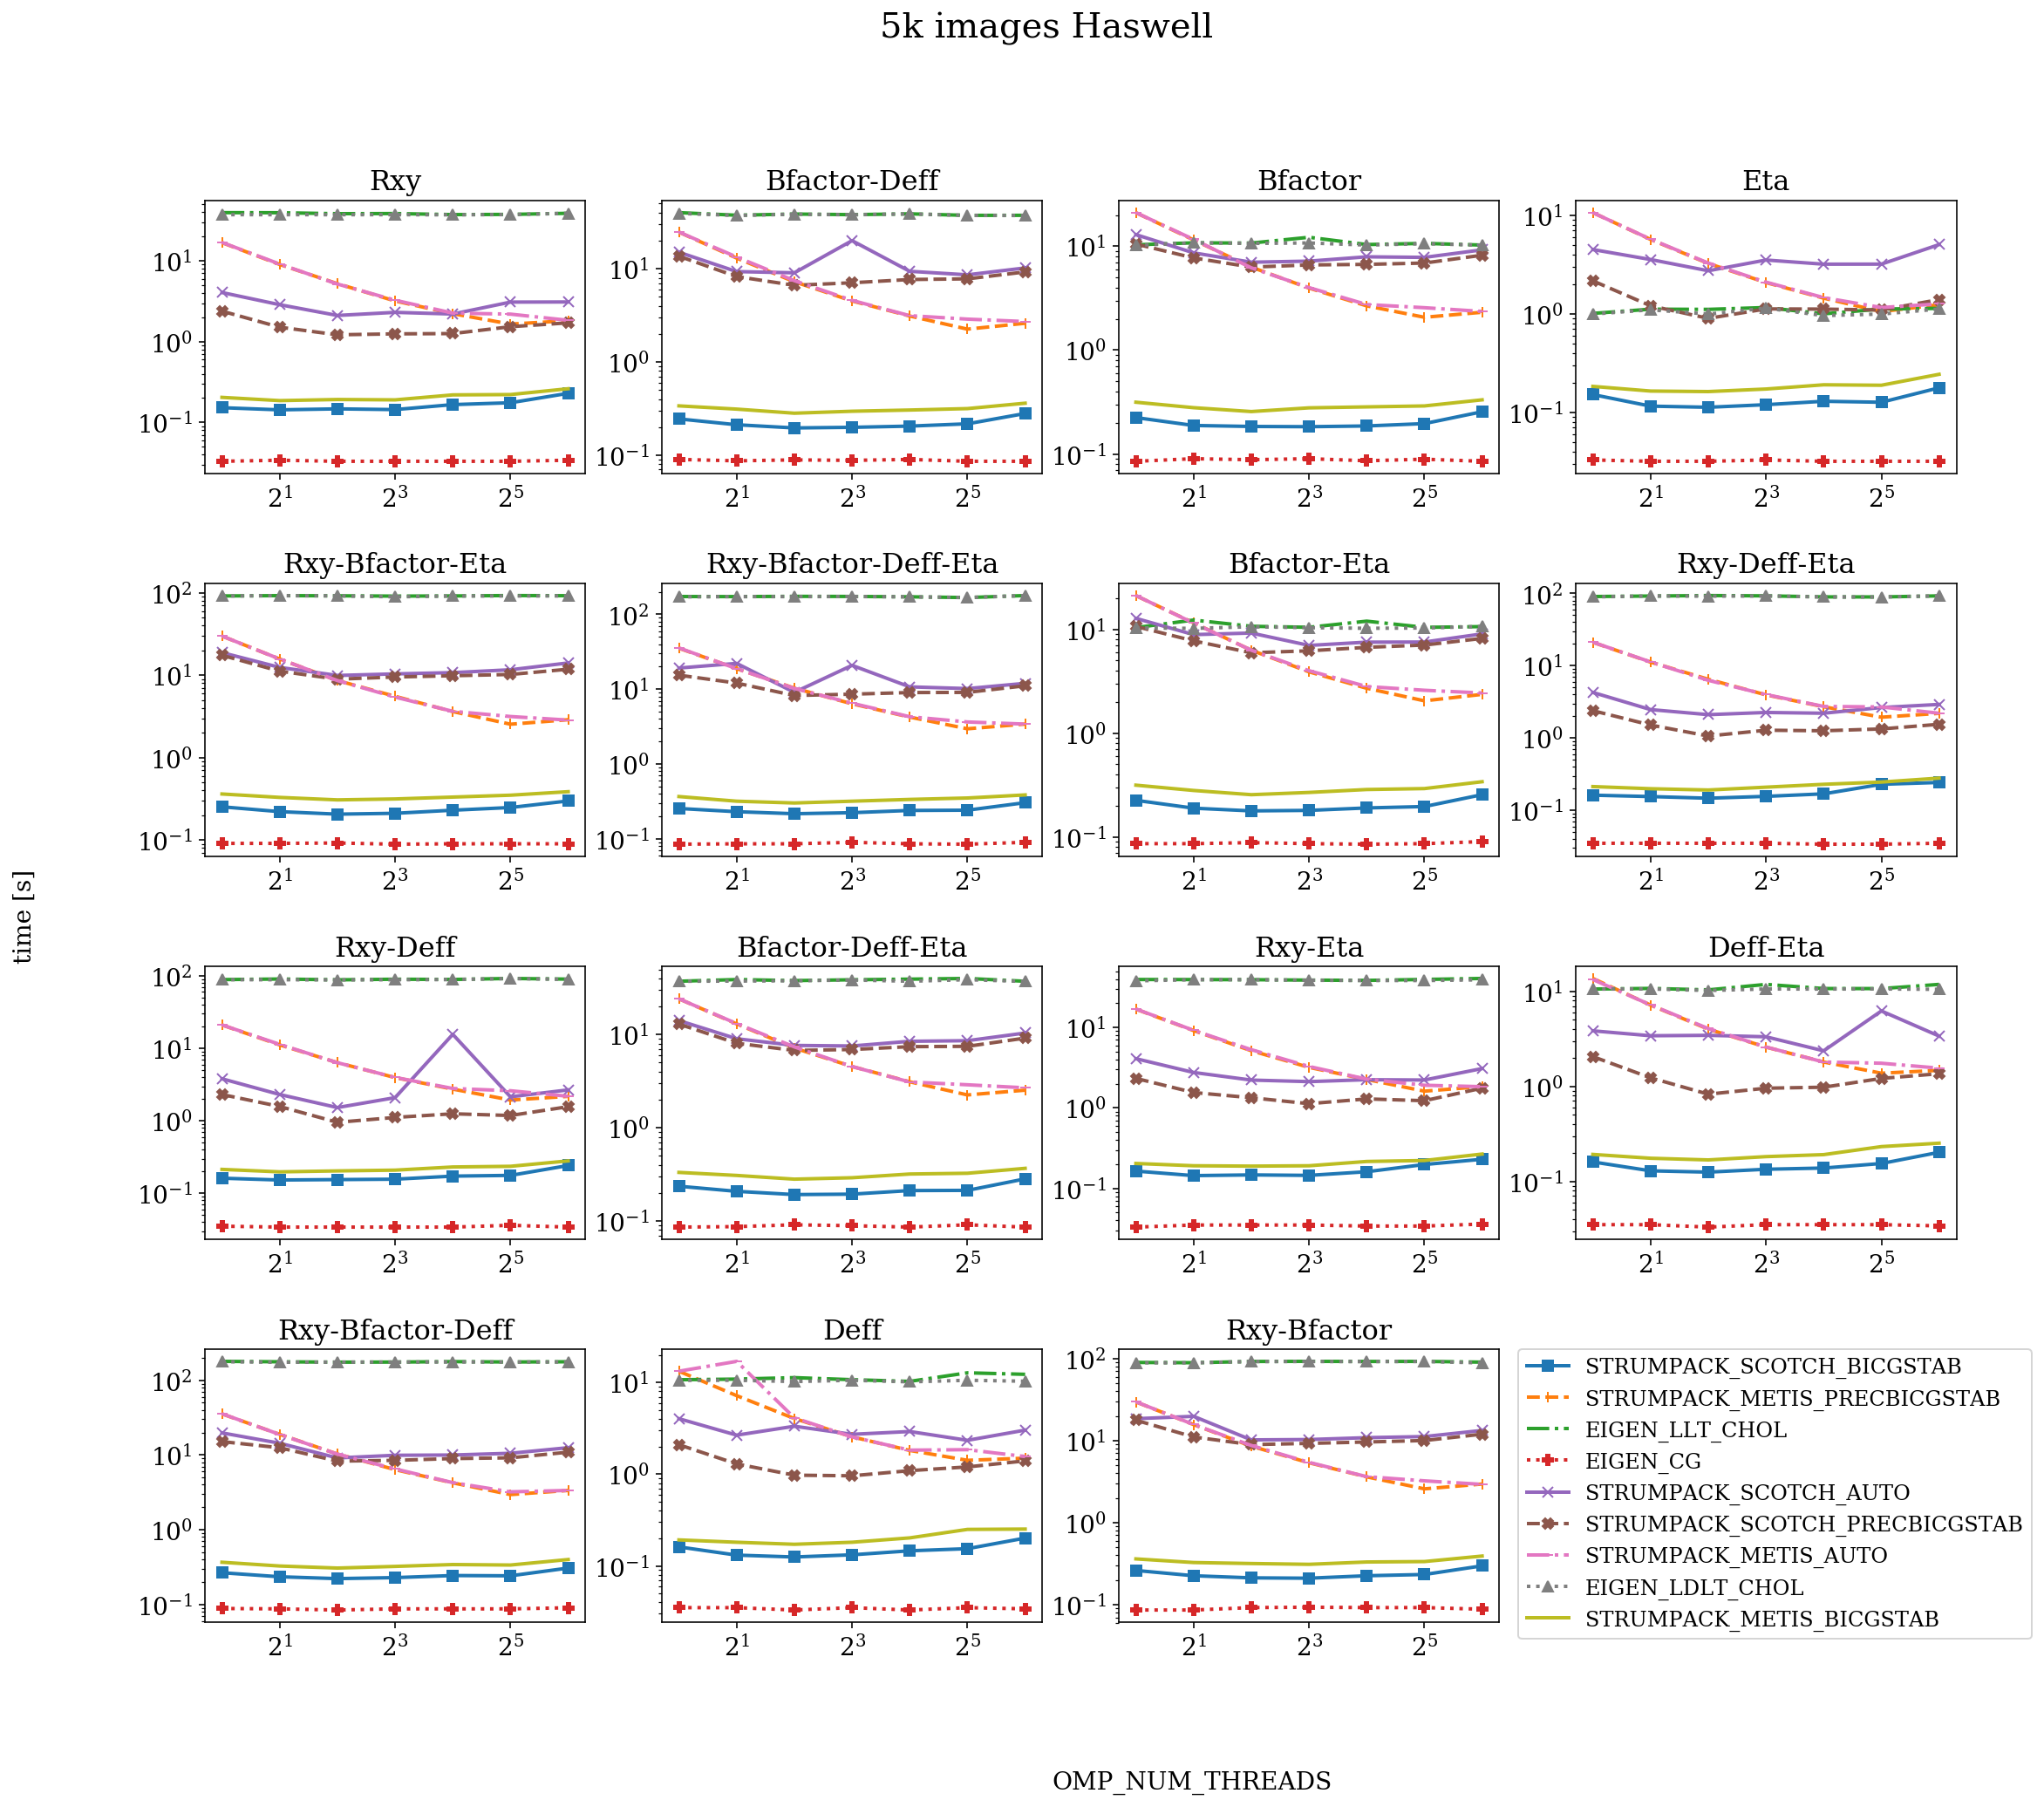

In [232]:
# define the figure size and grid layout properties
figsize = (18, 15)
cols = int(np.ceil(np.sqrt(len(params))))
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.4)
fig_hwl_omp = plt.figure(num=1, figsize=figsize)
fig_hwl_omp.suptitle('5k images Haswell ', size=20)
ax = []
cbars= []
import numpy as np
i=0

from itertools import cycle
lineStyles = ["-","--","-.",":"]

for p in params:
    row = (i // cols)
    col = i % cols
    ax.append(fig_hwl_omp.add_subplot(gs[row, col]))
    i+=1
    lineStyles_cycle = cycle(lineStyles)
    markerStyles_cycle = cycle(marker_list)
    next(markerStyles_cycle)
    for al_idx,al in enumerate(algos):

        cursor.execute('''SELECT omp_threads, time FROM hwl_omp WHERE ref_param=? AND algo=?''',(p,al))
        np_omp_t = np.array(cursor.fetchall(),dtype=[('OMP', '<i8'), ('time', '<f8')])
        np_omp_t.sort()
        dat = zip(*np_omp_t)

        cset = ax[-1].plot(dat[0], dat[1], label=al, linewidth=2, 
                           linestyle=next(lineStyles_cycle), marker=next(markerStyles_cycle) )
        
    ax[-1].set_title(p.replace('levmar.parameter_flags=','').replace('strum_5k_omp1_params',''), size=16 )
    plt.xscale('log',basex=2)
    plt.yscale('log',basey=10)


#gs.tight_layout(fig_hwl_omp,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
fig_hwl_omp.text(0.04, 0.5, 'time [s]', va='center', rotation='vertical')
fig_hwl_omp.text(0.5, 0.04, 'OMP_NUM_THREADS', va='center', rotation='horizontal')

plt.savefig('omp_5kframes_allsolvers_hwl_ompall.pdf',)

# OpenMP solver performance on KNL

In [9]:
SBATCH_SCRIPT_KNL=\
"""#!/bin/bash
#SBATCH -N 1
#SBATCH -C knl
#SBATCH -q regular
#SBATCH -o <DATNAME>_knl_out_OMP.log
#SBATCH -e <DATNAME>_knl_out_OMP.err
#SBATCH -J CCTBX_STRUMPACK
#SBATCH --mail-user=loriordan@lbl.gov
#SBATCH --mail-type=ALL
#SBATCH -t 03:00:00

#OpenMP settings:
#export OMP_PLACES=threads
#export OMP_PROC_BIND=spread

#run the application:
cd /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST
source $PWD/miniconda/bin/activate myEnv
source $PWD/build/setpaths.sh
module load darshan
export LD_LIBRARY_PATH=$CRAY_LD_LIBRARY_PATH:$LD_LIBRARY_PATH
mkdir -p OMP_KNL
cd OMP_KNL

mkdir <DATNAME>_knl_out_OMP
cd <DATNAME>_knl_out_OMP

#Use FPE mask to avoid floating point exceptions. Need to further investigate reasons for these
for n in 256;do
    t_c=$((256/${n}))
    echo "OMP_NUM_THREADS=${n} BOOST_ADAPTBX_FPE_DEFAULT=1 time srun -n 1 -c 272 --cpu_bind=cores\
        libtbx.python /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/OMP_SOLVER.py <DATA_A> <DATA_B>"
    OMP_NUM_THREADS=${n} BOOST_ADAPTBX_FPE_DEFAULT=1 srun -n 1 -c 272 --cpu_bind=cores libtbx.python \
      /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/OMP_SOLVER.py <DATA_A> <DATA_B>\
      1> <DATNAME>_knl_out_OMP${n}.log 2> <DATNAME>_knl_out_OMP${n}.err
done
cat <DATNAME>_knl_out_OMP${n}.log >> <DATNAME>_knl_out_OMP.log
cat <DATNAME>_knl_out_OMP${n}.err >> <DATNAME>_knl_out_OMP.err
"""

In [15]:
str_out={}
import os
threads_list = [1,2,4,8,16,32,64,128,256]
sub_scripts_knl = []
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        
        A_path = A_LIST[imgs_idx]; b_path = B_LIST[imgs_idx]
        dat_name = A_path.split('/')[-1][2:-4]

        print "Data Set Name:=%s"%(dat_name)

        #Ensure the A and b data are matched correctly
        assert(os.path.dirname(A_path) == os.path.dirname(b_path))
        SUBMIT = SBATCH_SCRIPT_KNL.replace('<DATA_A>',A_path)\
           .replace('<DATA_B>', b_path)\
           .replace('<DATNAME>', dat_name)
        SBATCH_SCRIPT_FILE = open("SBATCH_SCRIPT_knl_%s.sh"%(dat_name), "w")
        sub_scripts_knl.append("SBATCH_SCRIPT_knl_%s.sh"%(dat_name))
        SBATCH_SCRIPT_FILE.write(SUBMIT)
        SBATCH_SCRIPT_FILE.close()
        var = !sbatch {sub_scripts_knl[-1]}
        print var

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-
['Submitted batch job 11708194']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
['Submitted batch job 11708195']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
['Submitted batch job 11708198']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-
['Submitted batch job 11708199']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Eta-
['Submitted batch job 11708200']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-
['Submitted batch job 11708202']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-
['Submitted batch job 11708203']
Data Set Name:

In [16]:
sub_scripts_knl

['SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Eta-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Rxy-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Eta-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-.sh',
 'SBATCH_SCRIPT_knl_strum_5k_omp1_paramslevmar.par

In [73]:
dat_list_knl_omp = {}
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        
        dat = A_LIST[imgs_idx].split('/')[-1][2:-4]
        var = !find ./OMP_KNL -iname '{dat}_knl_out_OMP256.log' #!ls OMP_KNL/{dat}_knl_out_OMP/ | grep 'log'
        dat_list_knl_omp.update({dat : var})
        print dat
print dat_list_knl_omp

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-
strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-
strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Eta-
strum_5k_omp1_paramslevmar.parameter_flags=Rxy-
strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-
strum_5k_omp1_paramslevmar.parameter_flags=Eta-
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-
strum_5k_omp1_paramslevmar.parameter_flags=Deff-levmar.parameter_flags=Eta-
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-
strum_5k_omp1_paramslevmar.parameter_fl

Create dictionary of timing values organised by keys of data set name, followed by algorithm name mapping to the timings

In [103]:
time_data = {}
for key, value in dat_list_knl_omp.iteritems():
    with open(str(value[0])) as f:
        lines = f.read().splitlines()
        zlist = {}
        [zlist.update({l.split()[-7][:-1]:float(l.split()[-3][:-2])})\
          for l in lines if "#calls" in l]
        time_data.update({key : zlist})
print time_data

{'strum_5k_omp1_paramslevmar.parameter_flags=Deff-': {'STRUMPACK_SCOTCH_BICGSTAB': 0.679, 'STRUMPACK_METIS_PRECBICGSTAB': 5.431, 'EIGEN_LLT_CHOL': 54.04, 'EIGEN_CG': 0.101, 'STRUMPACK_SCOTCH_AUTO': 12.456, 'STRUMPACK_SCOTCH_PRECBICGSTAB': 8.861, 'STRUMPACK_METIS_AUTO': 5.288, 'EIGEN_LDLT_CHOL': 53.954, 'STRUMPACK_METIS_BICGSTAB': 0.921}, 'strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-': {'STRUMPACK_SCOTCH_BICGSTAB': 1.054, 'STRUMPACK_METIS_PRECBICGSTAB': 10.319, 'EIGEN_LLT_CHOL': 417.372, 'EIGEN_CG': 0.331, 'STRUMPACK_SCOTCH_AUTO': 61.092, 'STRUMPACK_SCOTCH_PRECBICGSTAB': 65.317, 'STRUMPACK_METIS_AUTO': 9.812, 'EIGEN_LDLT_CHOL': 417.778, 'STRUMPACK_METIS_BICGSTAB': 1.578}, 'strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-': {'STRUMPACK_SCOTCH_BICGSTAB': 1.114, 'STRUMPACK_METIS_PRECBICGSTAB': 11.211, 'EIGEN_LLT_CHOL': 810.343, 'EIGEN_CG': 0.327, 'STRUMPACK_SCOTCH_AUTO': 6

In [92]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        #'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (16,10)
matplotlib.rcParams['figure.dpi']= 150
import matplotlib.gridspec as gridspec

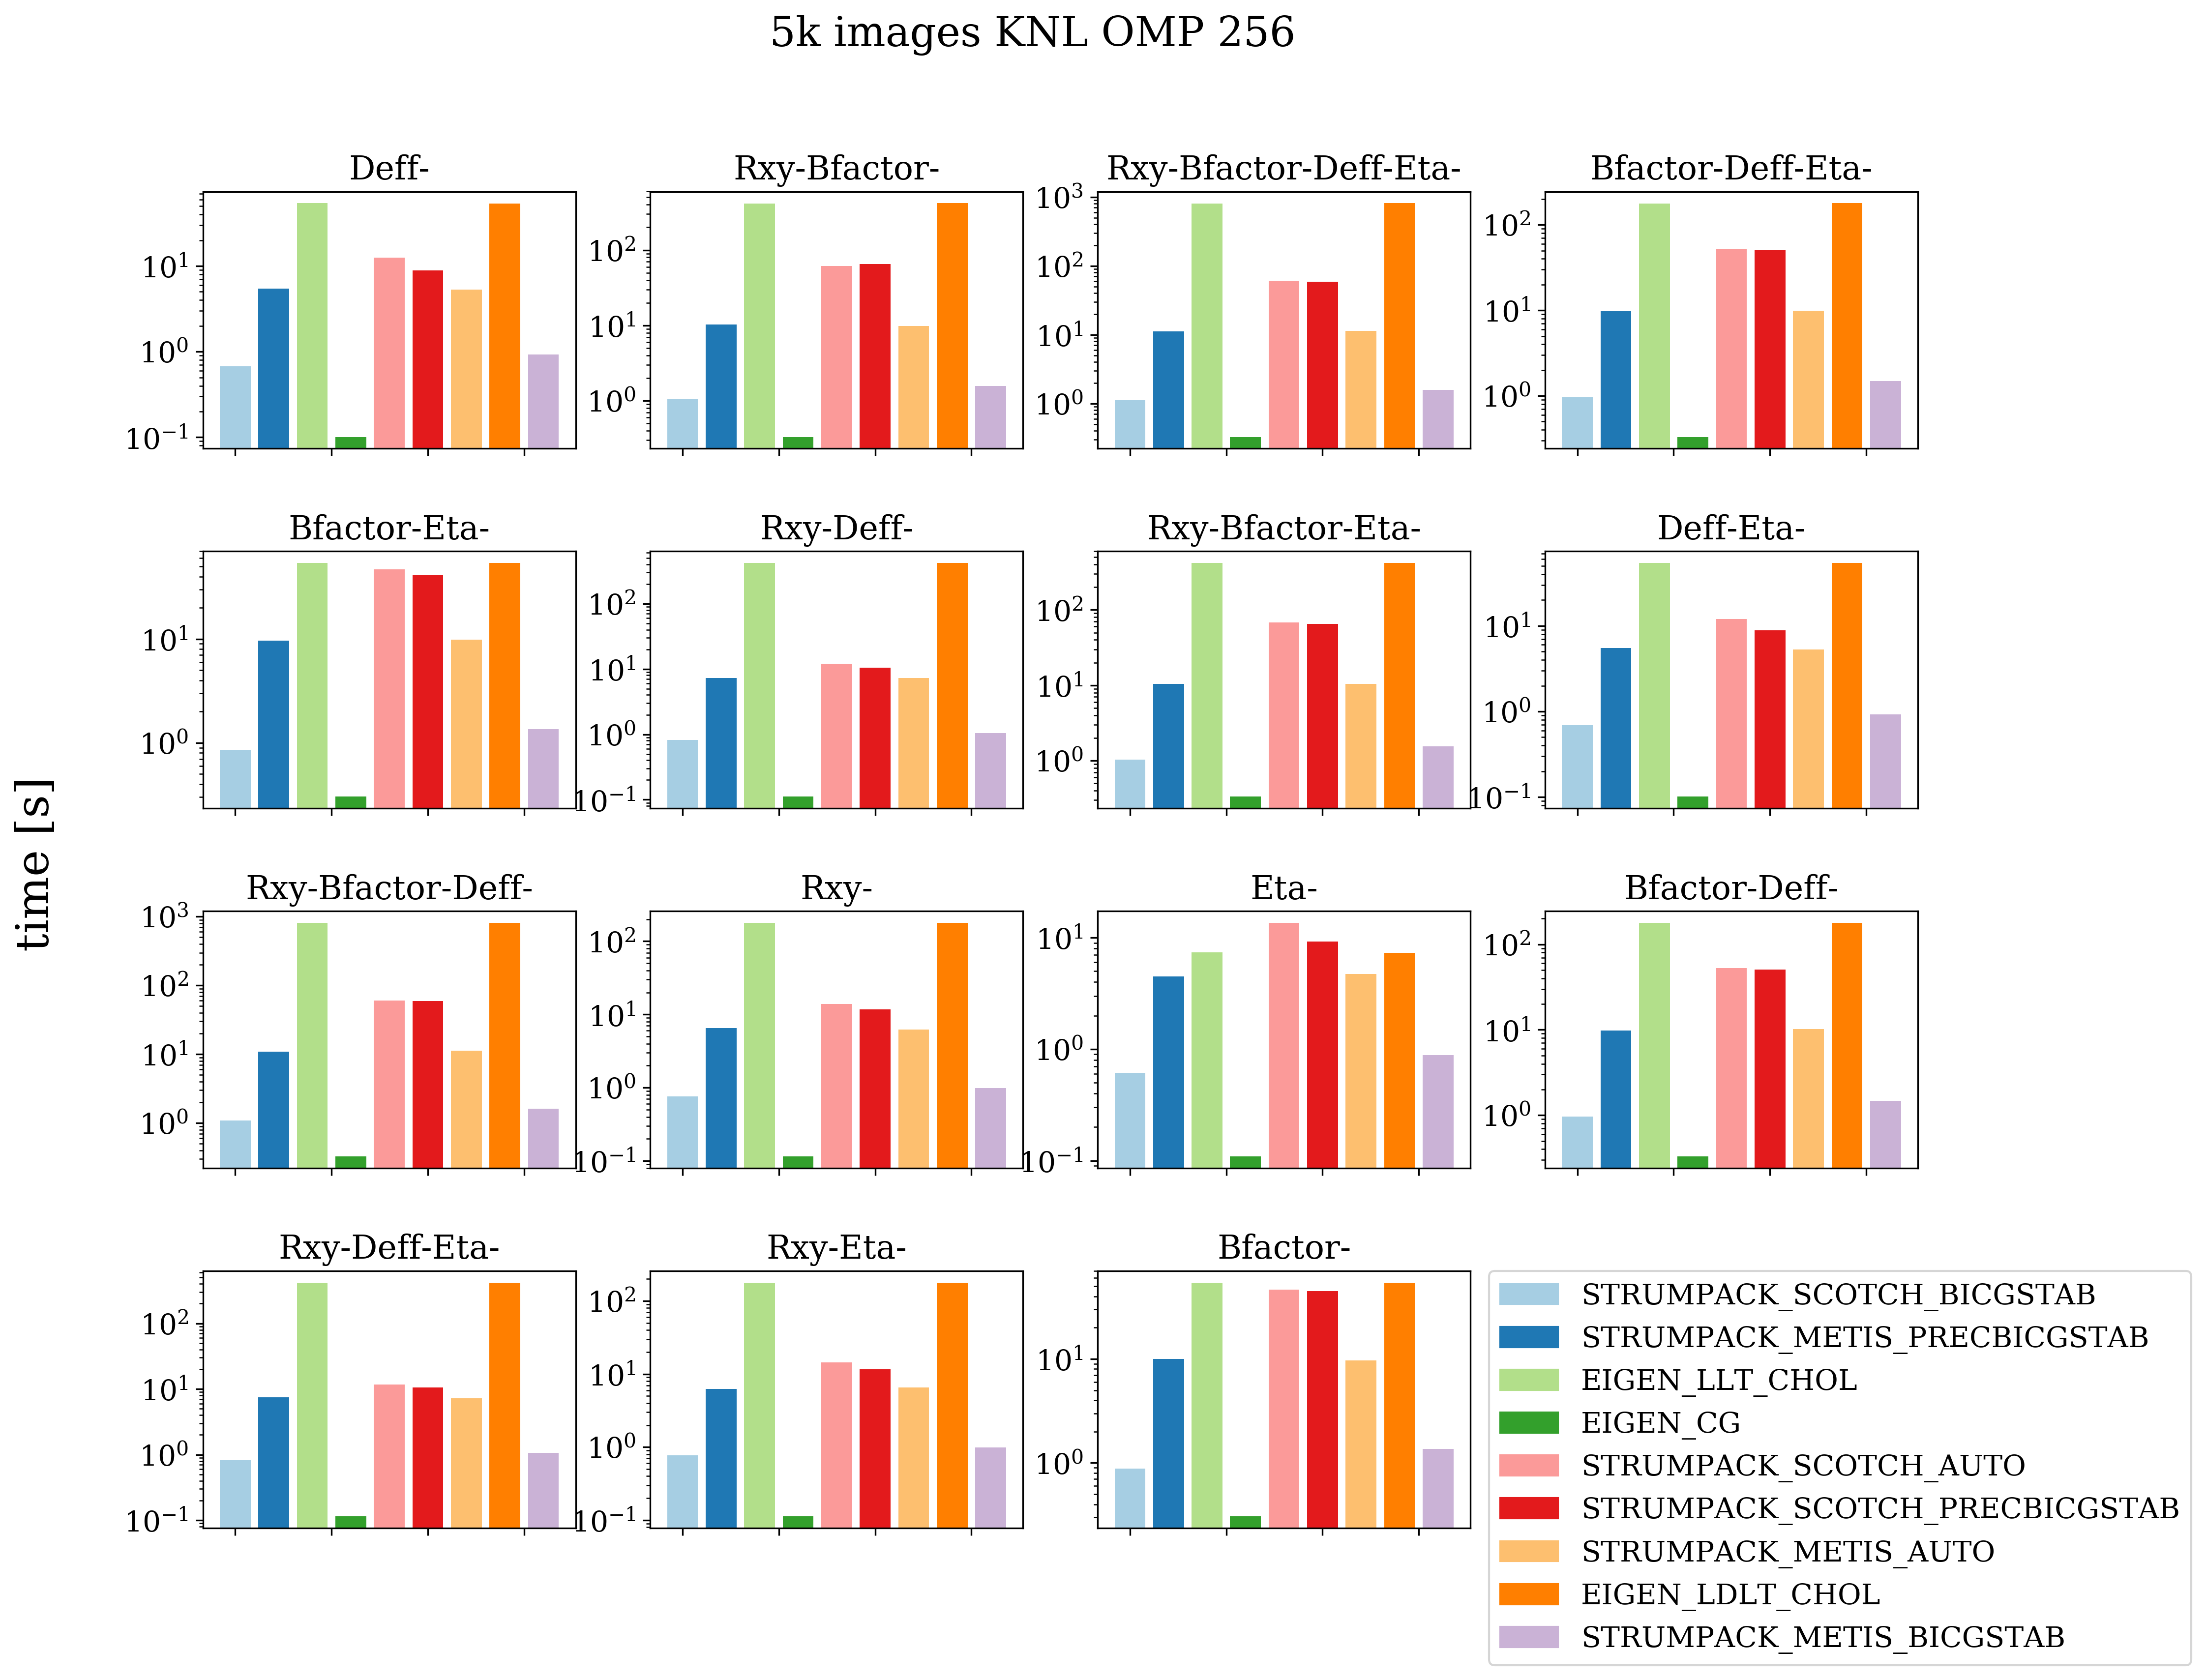

In [211]:
# define the figure size and grid layout properties
figsize = (15, 12)
cols = 4
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.4)
fig1 = plt.figure(num=1, figsize=figsize)
fig1.text(0.04, 0.5, 'time [s]', va='center', rotation='vertical')

fig1.suptitle('5k images KNL OMP 256', size=20)
ax = []
cbars= []

xlabels = time_data.itervalues().next().keys()
keys = time_data.itervalues().next().keys()
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
key_col = {k:v for (k,v) in zip(keys,colours)}

ax = []
i=0
matplotlib.rcParams.update({'font.size': 14})
for k,d in time_data.iteritems():
    
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    
    cset = ax[-1].bar(range(len(d)), d.values(), color=colours, align="center")
    ax[-1].set_title(k.replace('levmar.parameter_flags=','').replace('strum_5k_omp1_params',''), size=16 )
    ax[-1].set_xticklabels(['']*len(d.keys()))
    plt.yscale('log',basey=10)
    i+=1
    
# Ensure colours match the labels in the legend
leg_patch = []
for kk,vv in d.iteritems():
    leg_patch.append(mpatches.Patch(color=key_col[kk], label=kk))
plt.legend(handles=leg_patch,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)
plt.savefig('omp_1kframes_allsolvers_knl_omp256_grid.pdf', pad_inches=10)

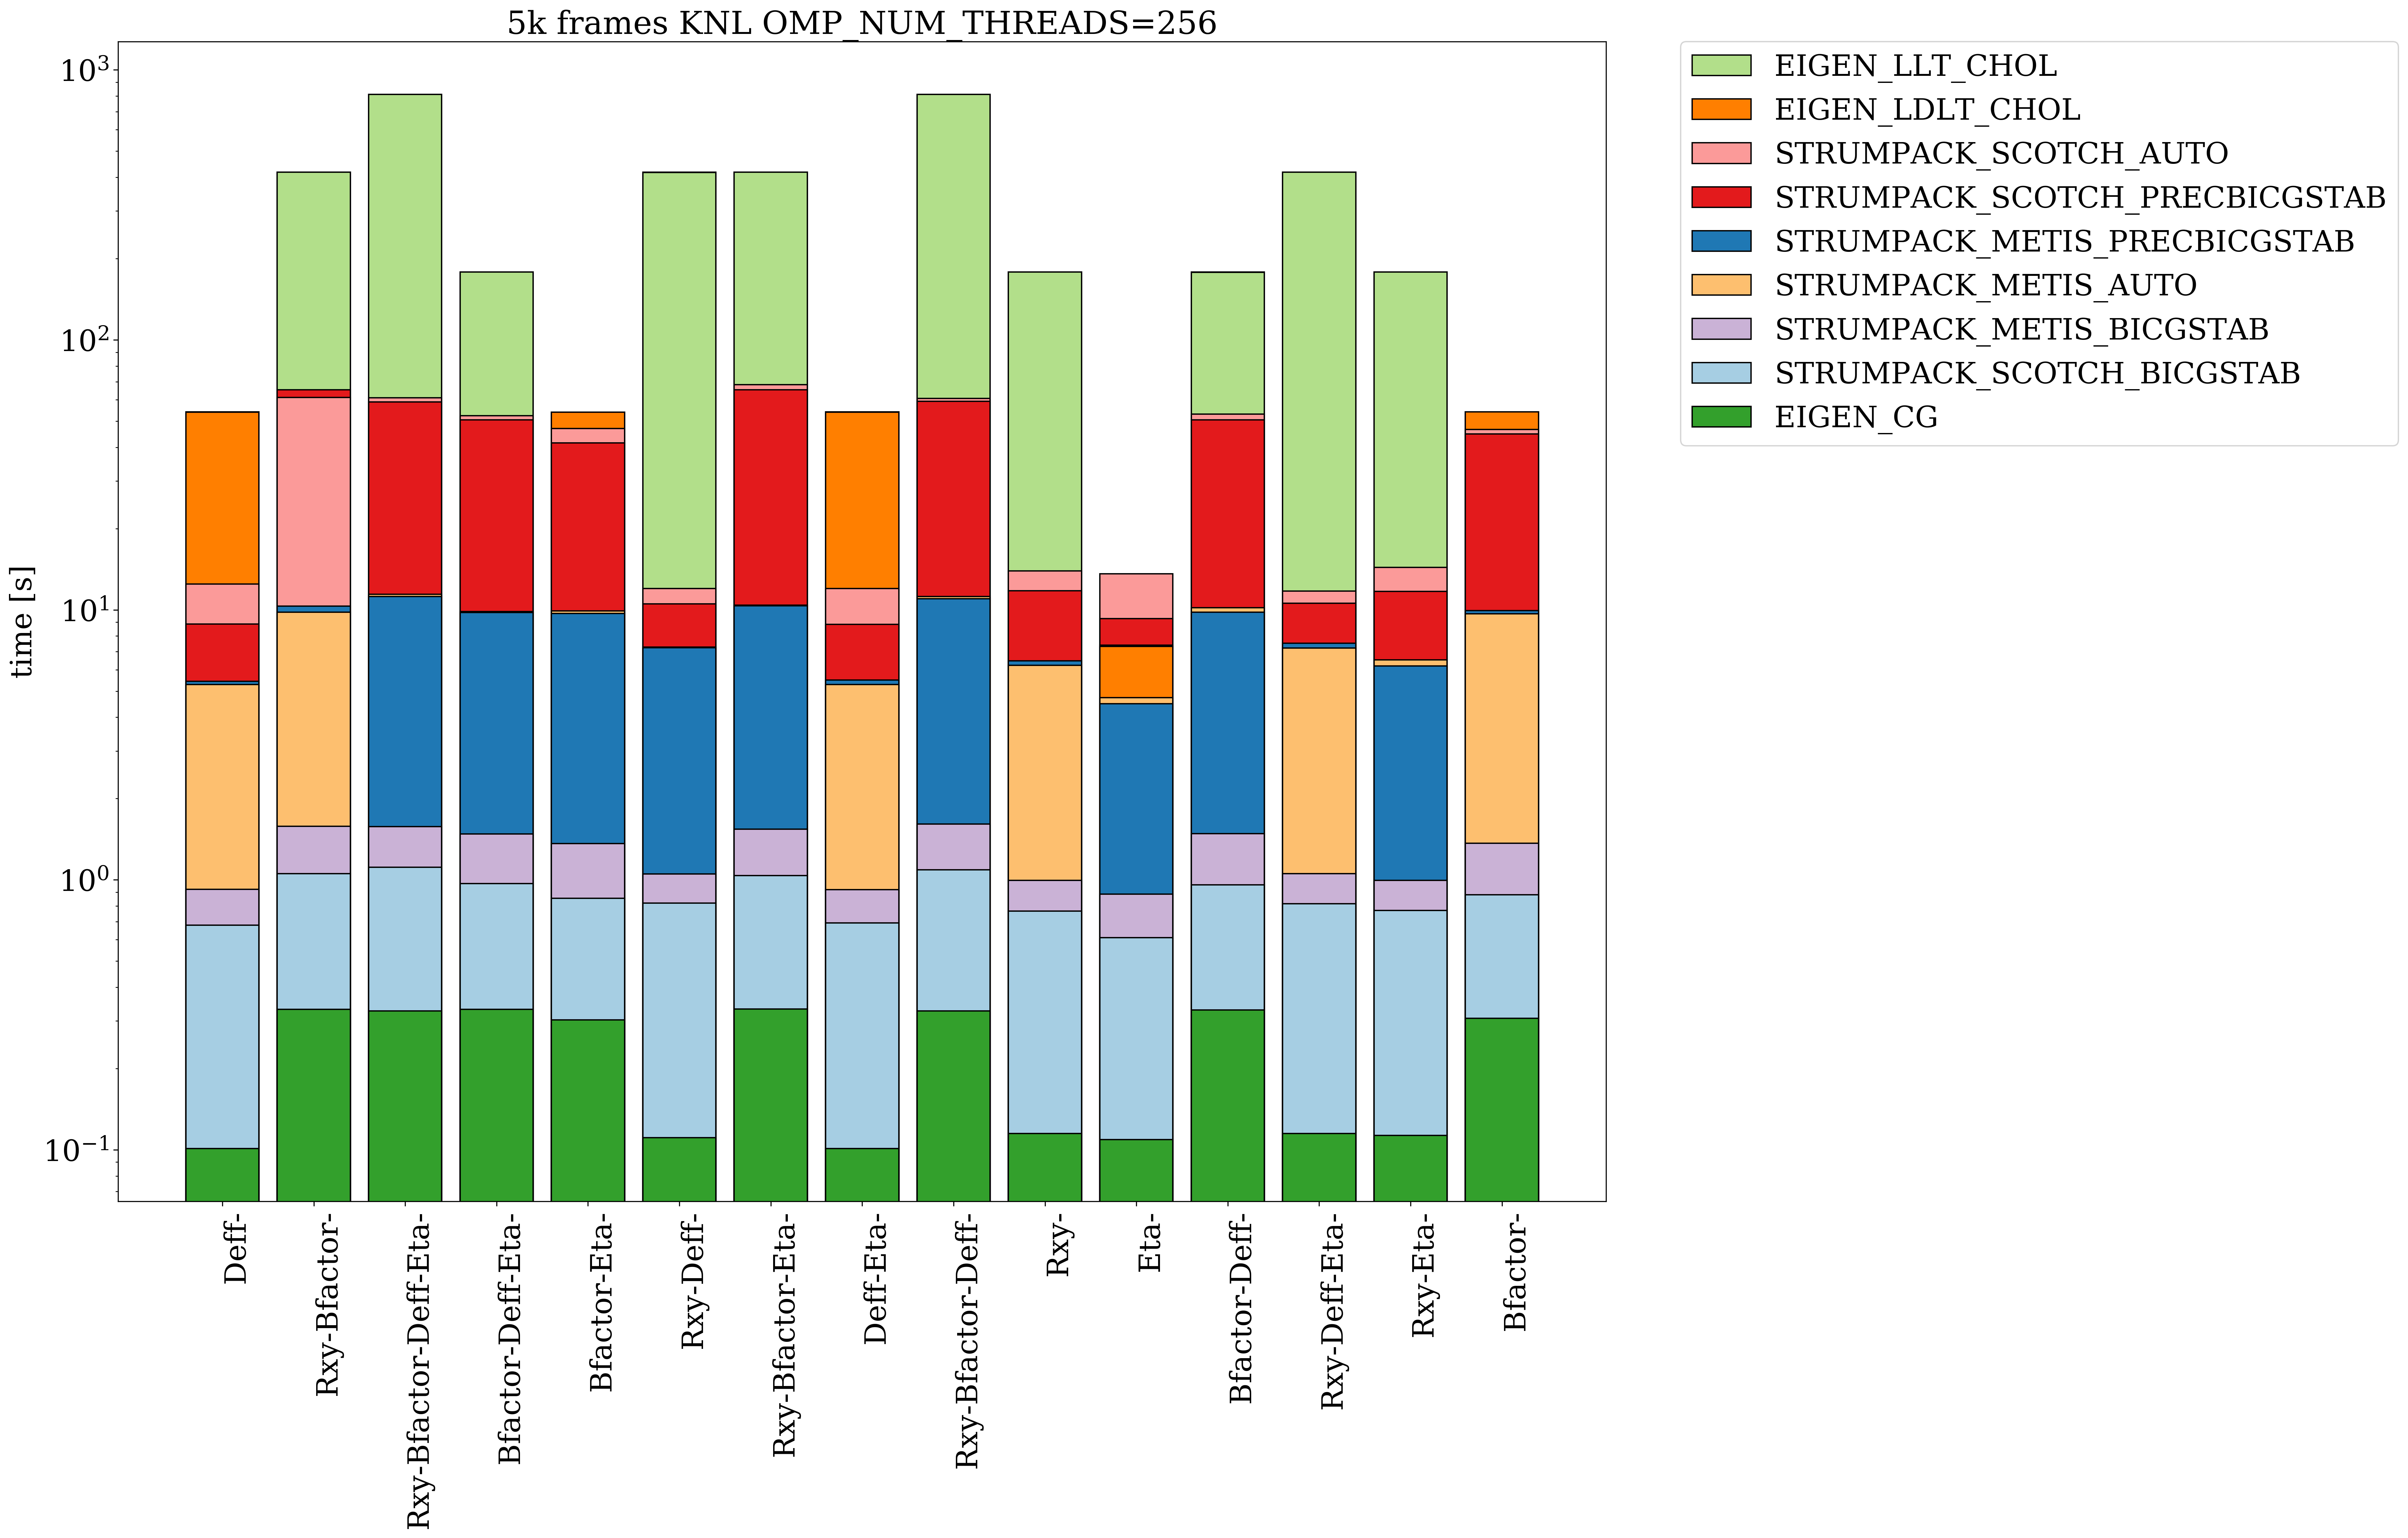

In [210]:
# define the figure size and grid layout properties
import matplotlib.patches as mpatches
matplotlib.rcParams.update({'font.size': 22})
figsize = (20, 16)
cols = 4
fig3 = plt.figure(num=3, figsize=figsize)
ax3 = plt.axes()
ii = []
uu=[]
xlabels = time_data.itervalues().next().keys()
keys = time_data.itervalues().next().keys()
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
key_col = {k:v for (k,v) in zip(keys,colours)}
hatch_pattern = [ '/' , '\\' , '|' , '-' , '+' , 'x' ,'o' ,'O' , '.', '*']
legend_set = False

for k, d in time_data.iteritems():
    p_list=[]
    ax3.set_ylabel('time [s]')

    m = zip(d.keys(), d.values())
    m = sorted(m,key=lambda x: x[1])
    c_patches = []
    for p in reversed(xrange(len(m))):
        pbar = plt.bar(k, m[p][1], label=m[p][0], color=key_col[m[p][0]], edgecolor='k')
        #Add legend items until end of first iteration through loop, then stop adding
            
        if p==0 and not legend_set: 
            legend_set=True
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)
ax3.set_yscale('log',basey=10)
plt.title('5k frames KNL OMP_NUM_THREADS=256', fontsize=24)
plt.setp(ax3.get_xticklabels(), rotation=90, ha='left')
xtl = [x.replace('levmar.parameter_flags=','').replace('strum_5k_omp1_params','') for x in time_data.keys()]
ax3.set_xticklabels(xtl);

plt.savefig('omp_5kframes_allsolvers_knl_omp256.pdf', pad_inches=10)

# MPI Performance on Haswell

We now use the same submission idea as the previous OpenMP examples, but using MPI instead. For a fully comprehensive exmaination of the various STRUMPACK methods used in the solution process, we examine almost all possible combinations using the parallel versions algorithms of SCOTCH and METIS, and all subsequent solver algorithms as listed above under the $\textrm{MPI STRUMPACK}$ set.

In [192]:
MPI_SOLVER='''
from __future__ import division

import mpi4py
mpi4py.rc.threads = True
mpi4py.rc.thread_level = "funneled"
from mpi4py import MPI

assert MPI.Is_initialized()
assert MPI.Query_thread() == MPI.THREAD_FUNNELED

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

from scitbx.matrix import sqr,col
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler

import boost.python
ext_omp = boost.python.import_ext("scitbx_examples_strumpack_solver_ext")
ext_mpi = boost.python.import_ext("scitbx_examples_strumpack_mpi_dist_solver_ext")
import sys
import numpy as np

import scipy.sparse as sps
len_x = None

if rank==0:
  A_mat = np.loadtxt(sys.argv[1],dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})
  b_vec = np.loadtxt(sys.argv[2])
  len_x = len(b_vec)
  n_rows = len(b_vec)
  n_cols = n_rows
  nnz = len(A_mat['vals'])
  print n_rows, n_rows/size
  #Convert the sparse CSR to flex doubles, then use them to solve using the implemented framework
  A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols']))) 

  #Check if upper/lower triangular only, and generate full if so
  tu=sps.triu(A_sp)
  tl=sps.tril(A_sp)
  sd=sps.diags(A_sp.diagonal())

  A_spS = A_sp
  if tu.nnz == sd.getnnz() or tl.nnz == sd.getnnz():
    A_spS = A_sp + A_sp.transpose() - sd

  import numpy as np
  row_idx_split = np.array_split(np.arange(n_rows),size)
  len_row_idx_split = flex.int( np.cumsum( np.append([0], [len(i) for i in row_idx_split]) ).tolist() )

  A_indptr = flex.int( A_spS.indptr )
  A_indices = flex.int( A_spS.indices )
  A_data = flex.double( A_spS.data )
  b = flex.double( b_vec )

  P = Profiler("EIGEN_CG")
  res_eig_cg = ext_omp.eigen_solver(3, n_rows, n_cols, A_indptr, A_indices, A_data, b)
  del P

else:
  A_spS=None
  row_idx_split=None
  len_row_idx_split=None
  b_vec=None
  n_cols=None

if size>1:
  #Broadcast data to each rank
  A_spS = comm.bcast(A_spS, root=0)
  row_idx_split = comm.bcast(row_idx_split, root=0)
  len_row_idx_split = comm.bcast(len_row_idx_split, root=0)
  b_vec = comm.bcast(b_vec, root=0)
  n_cols = comm.bcast(n_cols, root=0)

  #Take subset of data for each rank
  A_row_offset = flex.int(A_spS[row_idx_split[rank],:].indptr)
  A_col_offset = flex.int(A_spS[row_idx_split[rank],:].indices)
  A_values = flex.double(A_spS[row_idx_split[rank],:].data)
  b = flex.double(b_vec[row_idx_split[rank]])

  ################################################################################
  ################################################################################

  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_AUTO_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.auto)
  strum_result_mpi_PTSCOTCH_AUTO = comm.gather(res_strum_mpi_local.x, root=0)
  del P

  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.auto)
  strum_result_mpi_PARMETIS_AUTO = comm.gather(res_strum_mpi_local.x, root=0)
  del P

  ################################################################################
  ################################################################################
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_DIRECT_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.direct)
  strum_result_mpi_PTSCOTCH_DIRECT = comm.gather(res_strum_mpi_local.x, root=0)
  del P
      
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.direct)
  strum_result_mpi_PARMETIS_DIRECT = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################  
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_REFINE_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.refine)
  strum_result_mpi_PTSCOTCH_REFINE = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.refine)
  strum_result_mpi_PARMETIS_REFINE = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_PRECGMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.prec_gmres)
  strum_result_mpi_PTSCOTCH_PRECGMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.prec_gmres)
  strum_result_mpi_PARMETIS_PRECGMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_GMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.gmres)
  strum_result_mpi_PTSCOTCH_GMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.gmres)
  strum_result_mpi_PARMETIS_GMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_PRECBICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
    n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.prec_bicgstab)
  strum_result_mpi_PTSCOTCH_PRECBICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
    n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.prec_bicgstab)
  strum_result_mpi_PARMETIS_PRECBICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_BICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.bicgstab)
  strum_result_mpi_PTSCOTCH_BICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]),
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.bicgstab)
  strum_result_mpi_PARMETIS_BICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################
  if rank==0:
    PTSCOTCH_AUTO = flex.double()
    PARMETIS_AUTO = flex.double()
    PTSCOTCH_DIRECT = flex.double()
    PARMETIS_DIRECT = flex.double()
    PTSCOTCH_REFINE = flex.double()
    PARMETIS_REFINE = flex.double()
    PTSCOTCH_PRECGMRES = flex.double()
    PARMETIS_PRECGMRES = flex.double()
    PTSCOTCH_GMRES = flex.double()
    PARMETIS_GMRES = flex.double()
    PTSCOTCH_PRECBICGSTAB = flex.double()
    PARMETIS_PRECBICGSTAB = flex.double()
    PTSCOTCH_BICGSTAB = flex.double()
    PARMETIS_BICGSTAB = flex.double()
    for l in xrange(len(strum_result_mpi_PTSCOTCH_AUTO)):
      PTSCOTCH_AUTO.extend(strum_result_mpi_PTSCOTCH_AUTO[l])
      PARMETIS_AUTO.extend(strum_result_mpi_PARMETIS_AUTO[l])
      PTSCOTCH_DIRECT.extend(strum_result_mpi_PTSCOTCH_DIRECT[l])
      PARMETIS_DIRECT.extend(strum_result_mpi_PARMETIS_DIRECT[l])
      PTSCOTCH_REFINE.extend(strum_result_mpi_PTSCOTCH_REFINE[l])
      PARMETIS_REFINE.extend(strum_result_mpi_PARMETIS_REFINE[l])
      PTSCOTCH_PRECGMRES.extend(strum_result_mpi_PTSCOTCH_PRECGMRES[l])
      PARMETIS_PRECGMRES.extend(strum_result_mpi_PARMETIS_PRECGMRES[l])
      PTSCOTCH_GMRES.extend(strum_result_mpi_PTSCOTCH_GMRES[l])
      PARMETIS_GMRES.extend(strum_result_mpi_PARMETIS_GMRES[l])
      PTSCOTCH_PRECBICGSTAB.extend(strum_result_mpi_PTSCOTCH_PRECBICGSTAB[l])
      PARMETIS_PRECBICGSTAB.extend(strum_result_mpi_PARMETIS_PRECBICGSTAB[l])
      PTSCOTCH_BICGSTAB.extend(strum_result_mpi_PTSCOTCH_BICGSTAB[l])
      PARMETIS_BICGSTAB.extend(strum_result_mpi_PARMETIS_BICGSTAB[l])

if rank==0:  
  eps_tol=1e-3
  num_errors = 0
  for ii in xrange(len_x):
  ################################################################################
  ################################################################################
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_AUTO[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PARMETIS_AUTO:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_AUTO[ii], ii)
      
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_AUTO[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_DIRECT:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_AUTO[ii], ii)
  ################################################################################
  ################################################################################      
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_DIRECT[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_DIRECT:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_DIRECT[ii], ii)
      
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_DIRECT[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PARMETIS_DIRECT:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_DIRECT[ii], ii)
  ################################################################################
  ################################################################################      
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_REFINE[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_REFINE:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_REFINE[ii], ii)
      
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_REFINE[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PARMETIS_REFINE:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_REFINE[ii], ii)
      
  ################################################################################
  ################################################################################
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECGMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_PRECGMRES:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECGMRES[ii], ii)
      
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_PRECGMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PARMETIS_PRECGMRES:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_PRECGMRES[ii], ii)
  ################################################################################
  ################################################################################
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_GMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_GMRES:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_GMRES[ii], ii)
      
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_GMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PARMETIS_GMRES:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_GMRES[ii], ii)
  ################################################################################
  ################################################################################
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECBICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_PRECBICGSTAB:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECBICGSTAB[ii], ii)
      
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_PRECBICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PARMETIS_PRECBICGSTAB:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_PRECBICGSTAB[ii], ii)
  ################################################################################
  ################################################################################
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_BICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_BICGSTAB:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_BICGSTAB[ii], ii)
      
    if not approx_equal(PTSCOTCH_AUTO[ii], PARMETIS_BICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PARMETIS_BICGSTAB:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PARMETIS_BICGSTAB[ii], ii)
  ################################################################################
  ################################################################################

  assert (num_errors == 0)
'''

In [194]:
MPI_SOLVER_FILE = open("MPI_SOLVER.py", "w")
MPI_SOLVER_FILE.write(MPI_SOLVER)
MPI_SOLVER_FILE.close()

In [125]:
SBATCH_SCRIPT_MPI_HWL=\
"""#!/bin/bash
#SBATCH -N 1
#SBATCH -A m2859
#SBATCH -C haswell
#SBATCH -q regular
#SBATCH -o <DATNAME>_hwl_out_MPI.log
#SBATCH -e <DATNAME>_hwl_out_MPI.err
#SBATCH -J MPI_CCTBX_STRUMPACK
#SBATCH --mail-user=loriordan@lbl.gov
#SBATCH --mail-type=ALL
#SBATCH -t 03:00:00

#run the application:
cd /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST
source $PWD/miniconda/bin/activate myEnv
source $PWD/build/setpaths.sh
module swap PrgEnv-intel PrgEnv-gnu
module swap gcc gcc/4.9.3 
module load cray-mpich
module load darshan
export LD_LIBRARY_PATH=$CRAY_LD_LIBRARY_PATH:$LD_LIBRARY_PATH
mkdir -p MPI_HWL
cd MPI_HWL

mkdir -p <DATNAME>_hwl_out_MPI
cd <DATNAME>_hwl_out_MPI

#Use FPE mask to avoid floating point exceptions. Need to further investigate reasons for these
for n in 1 2 4 8 16 32;do
    t_c=$((256/${n}))
    echo "OMP_NUM_THREADS=1 BOOST_ADAPTBX_FPE_DEFAULT=1 srun -n ${n} -c 2 --cpu_bind=cores \
        libtbx.python /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/MPI_SOLVER.py <DATA_A> <DATA_B>"
    BOOST_ADAPTBX_FPE_DEFAULT=1 OMP_NUM_THREADS=1 srun -n ${n} -c 2 --cpu_bind=cores libtbx.python \
        /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/MPI_SOLVER.py <DATA_A> <DATA_B>\
        1> <DATNAME>_hwl_out_MPI${n}_OMP1.log \
        2> <DATNAME>_hwl_out_MPI${n}_OMP1.err
done
cat <DATNAME>_hwl_out_MPI${n}_OMP1.log >> <DATNAME>_hwl_out_MPI.log
cat <DATNAME>_hwl_out_MPI${n}_OMP1.err >> <DATNAME>_hwl_out_MPI.err
"""

In [196]:
str_out={}
import os
proc_list = [1,2,4,8,16,32]
sub_scripts = []
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        
        A_path = A_LIST[imgs_idx]; b_path = B_LIST[imgs_idx]
        dat_name = A_path.split('/')[-1][2:-4]

        print "Data Set Name:=%s"%(dat_name)

        #Ensure the A and b data are matched correctly
        assert(os.path.dirname(A_path) == os.path.dirname(b_path))
        SUBMIT = SBATCH_SCRIPT_MPI_HWL.replace('<DATA_A>',A_path)\
           .replace('<DATA_B>', b_path).replace('<DATNAME>', dat_name)
        SBATCH_SCRIPT_FILE = open("SBATCH_SCRIPT_MPI_%s.sh"%(dat_name), "w")
        sub_scripts.append("SBATCH_SCRIPT_MPI_%s.sh"%(dat_name))
        SBATCH_SCRIPT_FILE.write(SUBMIT)
        SBATCH_SCRIPT_FILE.close()
        var = !sbatch {sub_scripts[-1]}
        print var


Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-
['Submitted batch job 11742102']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
['Submitted batch job 11742103']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-
['Submitted batch job 11742104']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-
['Submitted batch job 11742105']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Eta-
['Submitted batch job 11742106']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-
['Submitted batch job 11742107']
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-
['Submitted batch job 11742108']
Data Set Name:

In [5]:
%squeue -u mlxd

Empty DataFrame
Columns: [JOBID, PARTITION, NAME, USER, ST, TIME, NODES, NODELIST(REASON)]
Index: []

We now extract the timing data from the output files.

In [71]:
dat_list_hwl_mpi = {}
procs_list = [1,2,4,8,16,32]
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        for MPI in procs_list:
            dat = A_LIST[imgs_idx].split('/')[-1][2:-4]
            var = !find ./MPI_HWL -iname '{dat}_hwl_out_MPI{MPI}_OMP1.log' #!ls OMP_KNL/{dat}_knl_out_OMP/ | grep 'log'
            dat_list_hwl_mpi.update({dat + str(MPI) : var})
print dat_list_hwl_mpi

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Data Set Size:=32k
Skipping 32k
{'strum_5k_omp1_paramslevmar.parameter_flags=Eta-16': ['./MPI_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI/strum_5k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI16_OMP1.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-4': ['./MPI_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-_hwl_out_MPI/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-_hwl_out_MPI4_OMP1.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-1': ['./MPI_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-_hwl_out_MPI/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-_hwl_out_MPI1_OMP1.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-8': ['./MPI_HWL/strum_5k_omp1_paramslevmar.paramet

In [76]:
time_data_hwl_mpi = {}
for key, value in dat_list_hwl_mpi.iteritems():
    try:
        with open(str(value[0])) as f:
            lines = f.read().splitlines()
            zlist = {}

            [zlist.update({l.split()[-7][:-1]:float(l.split()[-3][:-2])})\
              for l in lines if "#calls" in l if "RANK=0" in l]
            time_data_hwl_mpi.update({key : zlist})
    except Exception as e:
        #pass
        print "Could not find key:=%s; val:=%s"%(key,value)
print time_data_hwl_mpi

#Dictionary method
param_omp_val_t = { }

keyVal = time_data_hwl_mpi.iteritems().next()[0].split('-') #Param set name, and subsequent threads used
for k,v in time_data_hwl_mpi.iteritems():
    k_par_t = k.split('-')
d = { k_par_t[0]: {int(k_par_t[1]) : v} }

param_omp_val_t.update(d)

Could not find key:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-16; val:=[]
Could not find key:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-16; val:=[]
Could not find key:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-16; val:=[]
Could not find key:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-32; val:=[]
Could not find key:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-32; val:=[]
Could not find key:=strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-32; val:=[]
{'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-4': {'STRUMPACK_MPI_DIST_PARMETIS_BICGS

ValueError: invalid literal for int() with base 10: 'levmar.parameter_flags=Eta'

In [81]:
#DB method
import sqlite3
#conn.close()
conn = sqlite3.connect(':memory:')
# Get a cursor object
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE hwl_mpi(id INTEGER PRIMARY KEY, ref_param TEXT,
                       mpi_proc INTEGER, algo TEXT, time REAL)
''')
for k,v in time_data_hwl_mpi.iteritems():
    k_par_t = k.split('-')
    for kk,vv in v.iteritems():
        cursor.execute('''INSERT INTO hwl_mpi(ref_param, mpi_proc, algo, time)
                  VALUES(?,?,?,?)''', ("-".join(k_par_t[:-1]), k_par_t[-1], kk, vv))
conn.commit()

In [86]:
cursor.execute('''SELECT DISTINCT ref_param FROM hwl_mpi ''')
params = [s[0] for s in cursor.fetchall()]
cursor.execute('''SELECT DISTINCT algo FROM hwl_mpi ''')
algos = [s[0] for s in cursor.fetchall()]

par='strum_5k_omp1_paramslevmar.parameter_flags=Rxy'
cursor.execute('''SELECT ref_param, mpi_proc, algo, time FROM hwl_mpi WHERE ref_param=? AND algo=?''',(par,'STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0'))
all_rows = cursor.fetchall()
for row in all_rows:
    # row[0] returns the first column in the query (name), row[1] returns email column.
    print('{0} , {1}, {2} , {3}'.format(row[0], row[1], row[2], row[3]))

strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 32, STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0 , 1.245
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 16, STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0 , 1.267
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 4, STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0 , 0.95
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 2, STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0 , 0.987
strum_5k_omp1_paramslevmar.parameter_flags=Rxy , 8, STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0 , 1.059


In [147]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
xlabels = algos
keys = algos
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
key_col = {k:v for (k,v) in zip(keys,colours)}
marker_list=[l for l in matplotlib.markers.MarkerStyle.markers.keys() if not isinstance(l, (int))]

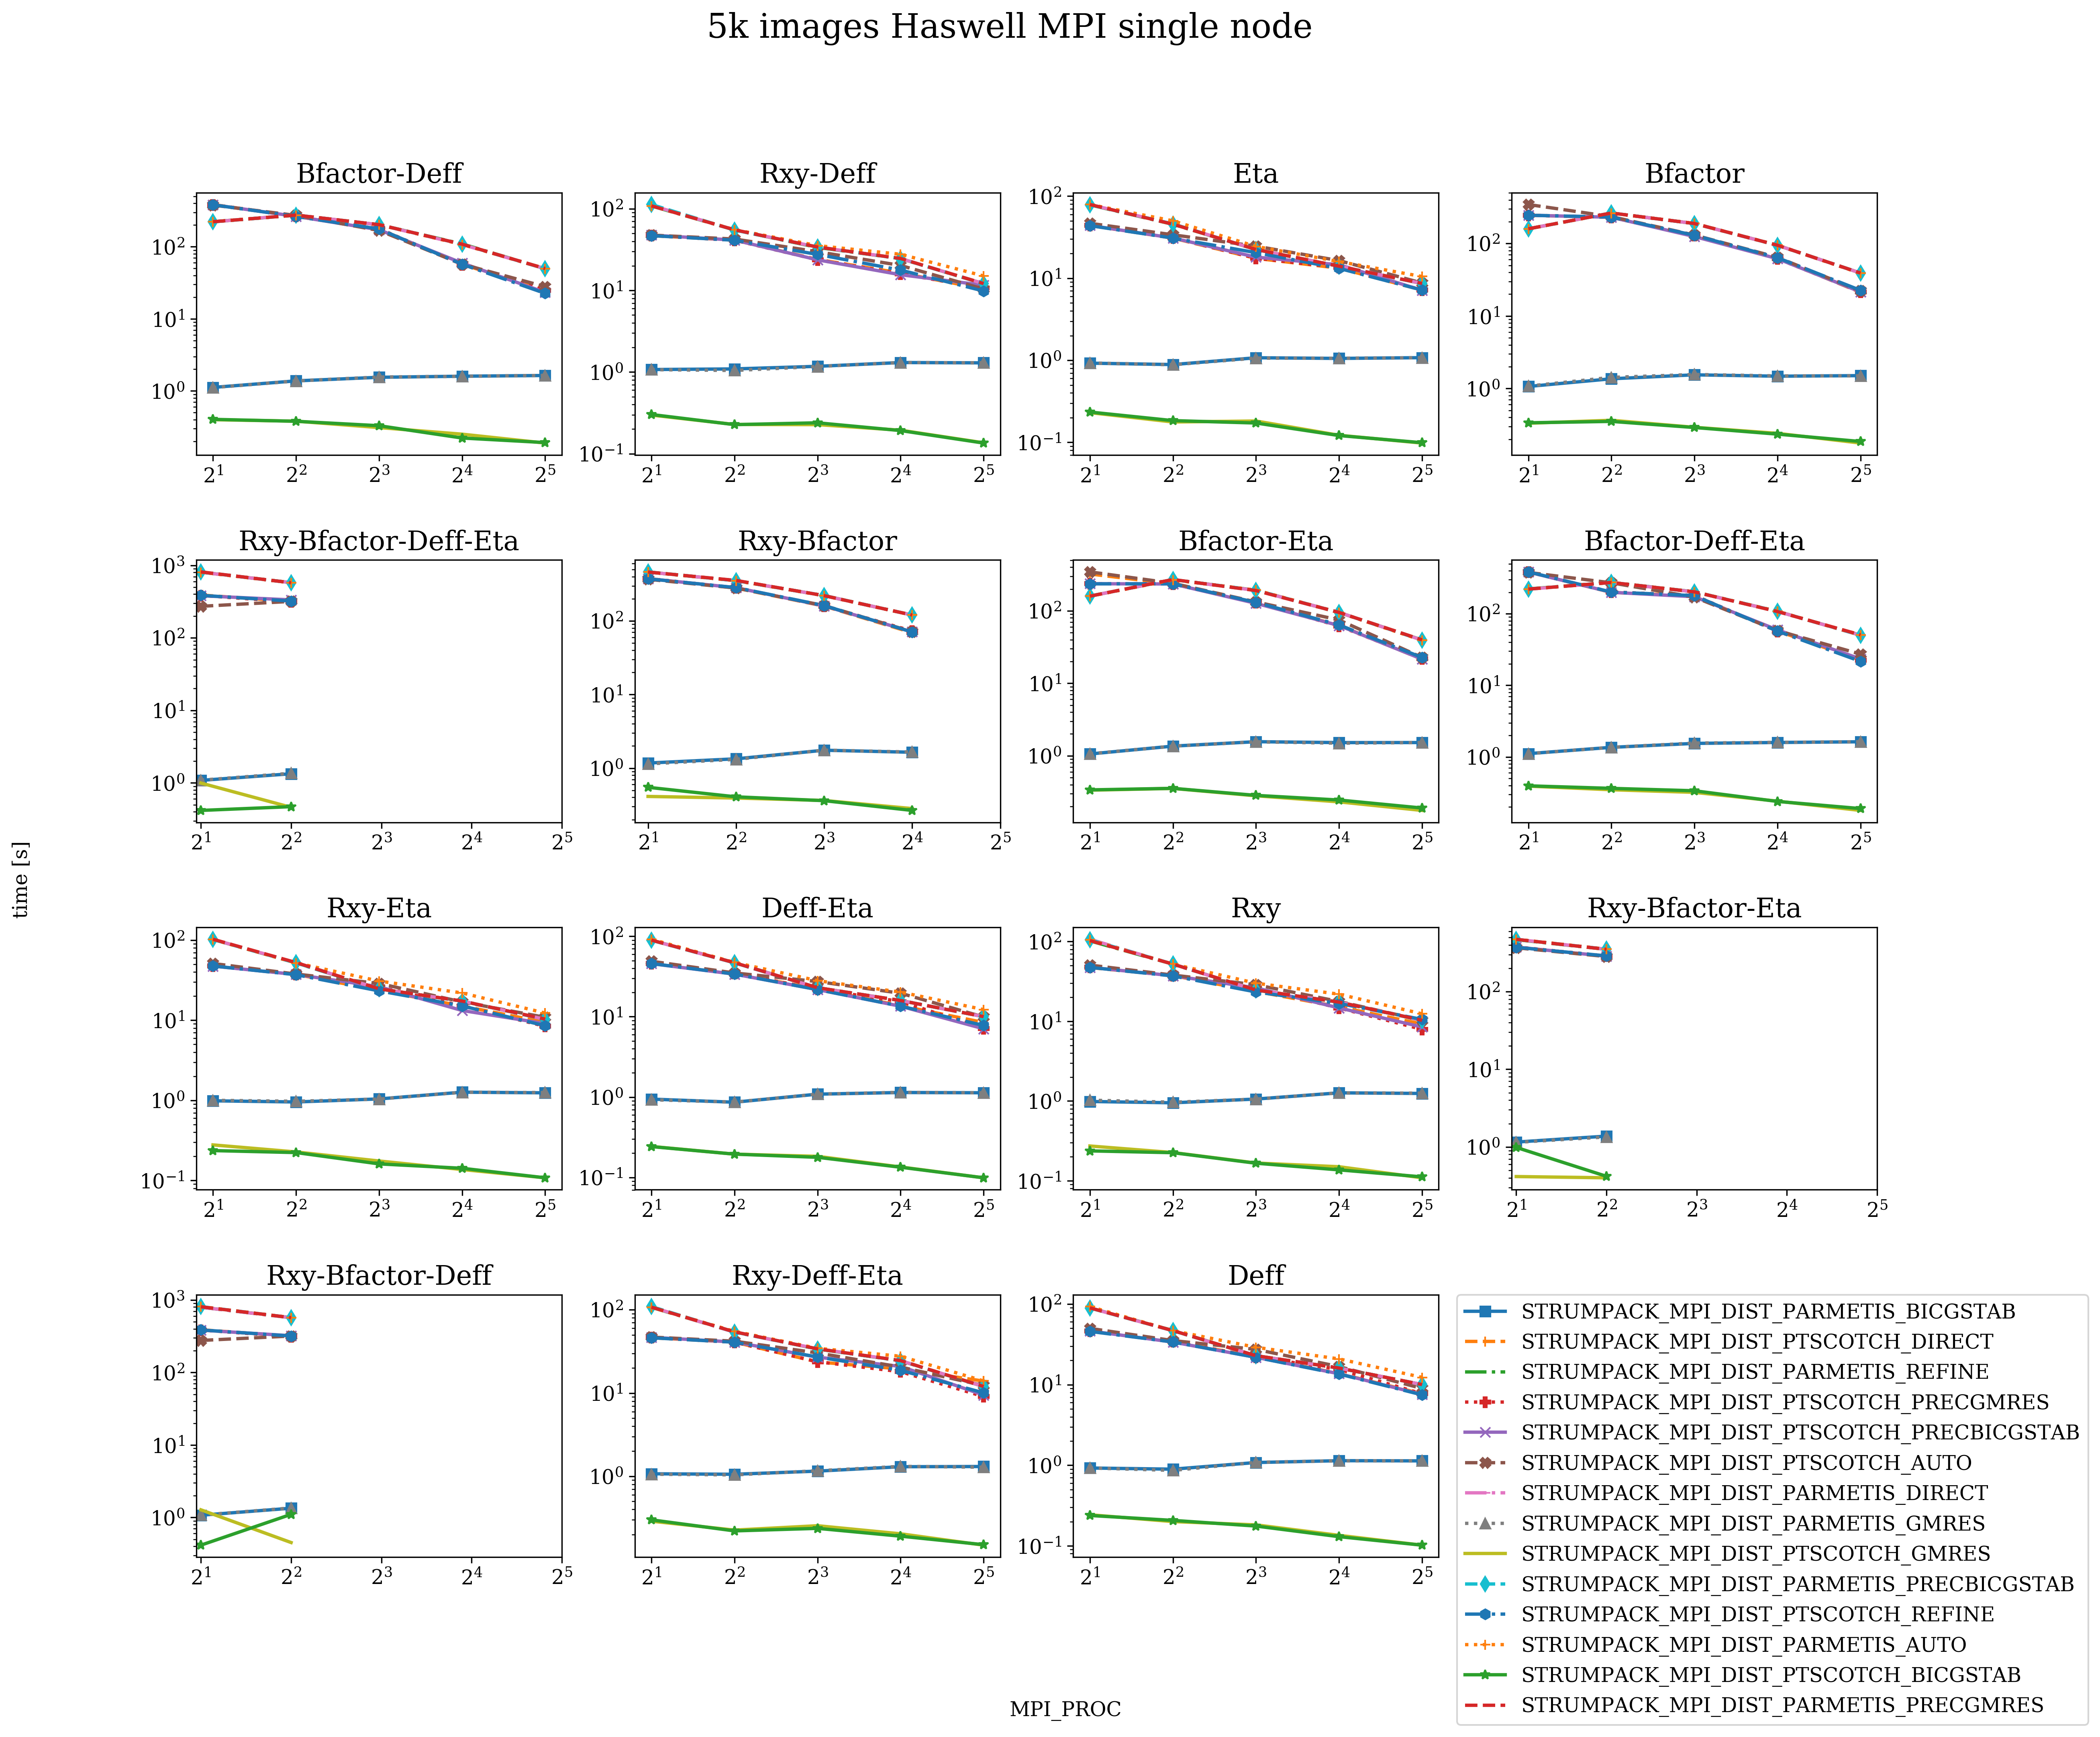

In [115]:
# define the figure size and grid layout properties
figsize = (18, 15)
cols = int(np.ceil(np.sqrt(len(params))))
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.4)
fig_hwl_mpi = plt.figure(num=1, figsize=figsize)
fig_hwl_mpi.suptitle('5k images Haswell MPI single node', size=20)
ax = []
cbars= []
import numpy as np
i=0

from itertools import cycle
lineStyles = ["-","--","-.",":"]

for p in params:
    row = (i // cols)
    col = i % cols
    ax.append(fig_hwl_mpi.add_subplot(gs[row, col]))
    i+=1
    lineStyles_cycle = cycle(lineStyles)
    markerStyles_cycle = cycle(marker_list)
    next(markerStyles_cycle)
    for al_idx,al in enumerate(algos):

        cursor.execute('''SELECT mpi_proc, time FROM hwl_mpi WHERE ref_param=? AND algo=?''',(p,al))
        np_omp_t = np.array(cursor.fetchall(),dtype=[('MPI', '<i8'), ('time', '<f8')])
        np_omp_t.sort()
        dat = zip(*np_omp_t)

        cset = ax[-1].plot(dat[0], dat[1], label=al.split("_RANK=0")[0], linewidth=2, 
                           linestyle=next(lineStyles_cycle), marker=next(markerStyles_cycle) )
        
    ax[-1].set_title(p.replace('levmar.parameter_flags=','').replace('strum_5k_omp1_params',''), size=16 )
    plt.xscale('log',basex=2)
    plt.yscale('log',basey=10)
    plt.xticks([2**n for n in xrange(1,6)])

#gs.tight_layout(fig_hwl_omp,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
fig_hwl_mpi.text(0.04, 0.5, 'time [s]', va='center', rotation='vertical')
fig_hwl_mpi.text(0.5, 0.04, 'MPI_PROC', va='center', rotation='horizontal')

plt.savefig('mpi_5kframes_allsolvers_hwl_mpiall.pdf',)

# Multiple nodes with MPI on Haswell

Now, we can examine the scalability of the above solvers across multiple nodes using MPI.

In [123]:
MPI_MULTI_SOLVER_PARMETIS='''
from __future__ import division

import mpi4py
mpi4py.rc.threads = True
mpi4py.rc.thread_level = "funneled"
from mpi4py import MPI

assert MPI.Is_initialized()
assert MPI.Query_thread() == MPI.THREAD_FUNNELED

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

from scitbx.matrix import sqr,col
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler

import boost.python
ext_omp = boost.python.import_ext("scitbx_examples_strumpack_solver_ext")
ext_mpi = boost.python.import_ext("scitbx_examples_strumpack_mpi_dist_solver_ext")
import sys
import numpy as np

import scipy.sparse as sps
len_x = None

if rank==0:
  A_mat = np.loadtxt(sys.argv[1],dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})
  b_vec = np.loadtxt(sys.argv[2])
  len_x = len(b_vec)
  n_rows = len(b_vec)
  n_cols = n_rows
  nnz = len(A_mat['vals'])
  print n_rows, n_rows/size
  #Convert the sparse CSR to flex doubles, then use them to solve using the implemented framework
  A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols']))) 

  #Check if upper/lower triangular only, and generate full if so
  tu=sps.triu(A_sp)
  tl=sps.tril(A_sp)
  sd=sps.diags(A_sp.diagonal())

  A_spS = A_sp
  if tu.nnz == sd.getnnz() or tl.nnz == sd.getnnz():
    A_spS = A_sp + A_sp.transpose() - sd

  import numpy as np
  row_idx_split = np.array_split(np.arange(n_rows),size)
  len_row_idx_split = flex.int( np.cumsum( np.append([0], [len(i) for i in row_idx_split]) ).tolist() )

  A_indptr = flex.int( A_spS.indptr )
  A_indices = flex.int( A_spS.indices )
  A_data = flex.double( A_spS.data )
  b = flex.double( b_vec )

  P = Profiler("EIGEN_CG")
  res_eig_cg = ext_omp.eigen_solver(3, n_rows, n_cols, A_indptr, A_indices, A_data, b)
  del P

else:
  A_spS=None
  row_idx_split=None
  len_row_idx_split=None
  b_vec=None
  n_cols=None

if size>1:
  #Broadcast data to each rank
  A_spS = comm.bcast(A_spS, root=0)
  row_idx_split = comm.bcast(row_idx_split, root=0)
  len_row_idx_split = comm.bcast(len_row_idx_split, root=0)
  b_vec = comm.bcast(b_vec, root=0)
  n_cols = comm.bcast(n_cols, root=0)

  #Take subset of data for each rank
  A_row_offset = flex.int(A_spS[row_idx_split[rank],:].indptr)
  A_col_offset = flex.int(A_spS[row_idx_split[rank],:].indices)
  A_values = flex.double(A_spS[row_idx_split[rank],:].data)
  b = flex.double(b_vec[row_idx_split[rank]])

  ################################################################################
  ################################################################################

  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.auto)
  strum_result_mpi_PARMETIS_AUTO = comm.gather(res_strum_mpi_local.x, root=0)
  del P

  ################################################################################
  ################################################################################
      
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.direct)
  strum_result_mpi_PARMETIS_DIRECT = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################  
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.refine)
  strum_result_mpi_PARMETIS_REFINE = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.prec_gmres)
  strum_result_mpi_PARMETIS_PRECGMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.gmres)
  strum_result_mpi_PARMETIS_GMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################

  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
    n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.prec_bicgstab)
  strum_result_mpi_PARMETIS_PRECBICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  
  P = Profiler("STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]),
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.parmetis, ext_mpi.bicgstab)
  strum_result_mpi_PARMETIS_BICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  if rank==0:
    PARMETIS_AUTO = flex.double()
    PARMETIS_DIRECT = flex.double()
    PARMETIS_REFINE = flex.double()
    PARMETIS_PRECGMRES = flex.double()
    PARMETIS_GMRES = flex.double()
    PARMETIS_PRECBICGSTAB = flex.double()
    PARMETIS_BICGSTAB = flex.double()
    for l in xrange(len(strum_result_mpi_PARMETIS_BICGSTAB)):
      PARMETIS_AUTO.extend(strum_result_mpi_PARMETIS_AUTO[l])
      PARMETIS_DIRECT.extend(strum_result_mpi_PARMETIS_DIRECT[l])
      PARMETIS_REFINE.extend(strum_result_mpi_PARMETIS_REFINE[l])
      PARMETIS_PRECGMRES.extend(strum_result_mpi_PARMETIS_PRECGMRES[l])
      PARMETIS_GMRES.extend(strum_result_mpi_PARMETIS_GMRES[l])
      PARMETIS_PRECBICGSTAB.extend(strum_result_mpi_PARMETIS_PRECBICGSTAB[l])
      PARMETIS_BICGSTAB.extend(strum_result_mpi_PARMETIS_BICGSTAB[l])

if rank==0:  
  eps_tol=1e-3
  num_errors = 0
  for ii in xrange(len_x):
  ################################################################################
  ################################################################################
  
    if not approx_equal(PARMETIS_AUTO[ii], PARMETIS_DIRECT[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PARMETIS_AUTO:=%f != PARMETIS_DIRECT:=%f @ [%d] "%(PARMETIS_AUTO[ii], PARMETIS_DIRECT[ii], ii)
      
  ################################################################################
  ################################################################################ 
  
    if not approx_equal(PARMETIS_AUTO[ii], PARMETIS_REFINE[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PARMETIS_AUTO:=%f != PARMETIS_REFINE:=%f @ [%d] "%(PARMETIS_AUTO[ii], PARMETIS_REFINE[ii], ii)
      
  ################################################################################
  ################################################################################      
    if not approx_equal(PARMETIS_AUTO[ii], PARMETIS_PRECGMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PARMETIS_AUTO:=%f != PARMETIS_PRECGMRES:=%f @ [%d] "%(PARMETIS_AUTO[ii], PARMETIS_PRECGMRES[ii], ii)
      
  ################################################################################
  ################################################################################
  
    if not approx_equal(PARMETIS_AUTO[ii], PARMETIS_GMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PARMETIS_AUTO:=%f != PARMETIS_GMRES:=%f @ [%d] "%(PARMETIS_AUTO[ii], PARMETIS_GMRES[ii], ii)
      
  ################################################################################
  ################################################################################
  
    if not approx_equal(PARMETIS_AUTO[ii], PARMETIS_PRECBICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PARMETIS_AUTO:=%f != PARMETIS_PRECBICGSTAB:=%f @ [%d] "%(PARMETIS_AUTO[ii], PARMETIS_PRECBICGSTAB[ii], ii)
      
  ################################################################################
  ################################################################################
  
    if not approx_equal(PARMETIS_AUTO[ii], PARMETIS_BICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PARMETIS_AUTO:=%f != PARMETIS_BICGSTAB:=%f @ [%d] "%(PARMETIS_AUTO[ii], PARMETIS_BICGSTAB[ii], ii)
      
   ################################################################################
  ################################################################################
 
  assert (num_errors == 0)
'''
MPI_MULTI_SOLVER_FILE = open("MPI_MULTI_SOLVER_PARMETIS.py", "w")
MPI_MULTI_SOLVER_FILE.write(MPI_MULTI_SOLVER_PARMETIS)
MPI_MULTI_SOLVER_FILE.close()

In [130]:
MPI_MULTI_SOLVER_PTSCOTCH='''
from __future__ import division

import mpi4py
mpi4py.rc.threads = True
mpi4py.rc.thread_level = "funneled"
from mpi4py import MPI

assert MPI.Is_initialized()
assert MPI.Query_thread() == MPI.THREAD_FUNNELED

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

from scitbx.matrix import sqr,col
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler

import boost.python
ext_omp = boost.python.import_ext("scitbx_examples_strumpack_solver_ext")
ext_mpi = boost.python.import_ext("scitbx_examples_strumpack_mpi_dist_solver_ext")
import sys
import numpy as np

import scipy.sparse as sps
len_x = None

if rank==0:
  A_mat = np.loadtxt(sys.argv[1],dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})
  b_vec = np.loadtxt(sys.argv[2])
  len_x = len(b_vec)
  n_rows = len(b_vec)
  n_cols = n_rows
  nnz = len(A_mat['vals'])
  print n_rows, n_rows/size
  #Convert the sparse CSR to flex doubles, then use them to solve using the implemented framework
  A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols']))) 

  #Check if upper/lower triangular only, and generate full if so
  tu=sps.triu(A_sp)
  tl=sps.tril(A_sp)
  sd=sps.diags(A_sp.diagonal())

  A_spS = A_sp
  if tu.nnz == sd.getnnz() or tl.nnz == sd.getnnz():
    A_spS = A_sp + A_sp.transpose() - sd

  import numpy as np
  row_idx_split = np.array_split(np.arange(n_rows),size)
  len_row_idx_split = flex.int( np.cumsum( np.append([0], [len(i) for i in row_idx_split]) ).tolist() )

  A_indptr = flex.int( A_spS.indptr )
  A_indices = flex.int( A_spS.indices )
  A_data = flex.double( A_spS.data )
  b = flex.double( b_vec )

  P = Profiler("EIGEN_CG")
  res_eig_cg = ext_omp.eigen_solver(3, n_rows, n_cols, A_indptr, A_indices, A_data, b)
  del P

else:
  A_spS=None
  row_idx_split=None
  len_row_idx_split=None
  b_vec=None
  n_cols=None

if size>1:
  #Broadcast data to each rank
  A_spS = comm.bcast(A_spS, root=0)
  row_idx_split = comm.bcast(row_idx_split, root=0)
  len_row_idx_split = comm.bcast(len_row_idx_split, root=0)
  b_vec = comm.bcast(b_vec, root=0)
  n_cols = comm.bcast(n_cols, root=0)

  #Take subset of data for each rank
  A_row_offset = flex.int(A_spS[row_idx_split[rank],:].indptr)
  A_col_offset = flex.int(A_spS[row_idx_split[rank],:].indices)
  A_values = flex.double(A_spS[row_idx_split[rank],:].data)
  b = flex.double(b_vec[row_idx_split[rank]])

  ################################################################################
  ################################################################################

  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_AUTO_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.auto)
  strum_result_mpi_PTSCOTCH_AUTO = comm.gather(res_strum_mpi_local.x, root=0)
  del P

  ################################################################################
  ################################################################################
      
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_DIRECT_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.direct)
  strum_result_mpi_PTSCOTCH_DIRECT = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  ################################################################################
  ################################################################################  
  
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_REFINE_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.refine)
  strum_result_mpi_PTSCOTCH_REFINE = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_PRECGMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.prec_gmres)
  strum_result_mpi_PTSCOTCH_PRECGMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_GMRES_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.gmres)
  strum_result_mpi_PTSCOTCH_GMRES = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################

  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_PRECBICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), 
    n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.prec_bicgstab)
  strum_result_mpi_PTSCOTCH_PRECBICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  
  P = Profiler("STRUMPACK_MPI_DIST_PTSCOTCH_BICGSTAB_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]),
      n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.ptscotch, ext_mpi.bicgstab)
  strum_result_mpi_PTSCOTCH_BICGSTAB = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  
  ################################################################################
  ################################################################################
  if rank==0:
    PTSCOTCH_AUTO = flex.double()
    PTSCOTCH_DIRECT = flex.double()
    PTSCOTCH_REFINE = flex.double()
    PTSCOTCH_PRECGMRES = flex.double()
    PTSCOTCH_GMRES = flex.double()
    PTSCOTCH_PRECBICGSTAB = flex.double()
    PTSCOTCH_BICGSTAB = flex.double()
    for l in xrange(len(strum_result_mpi_PTSCOTCH_BICGSTAB)):
      PTSCOTCH_AUTO.extend(strum_result_mpi_PTSCOTCH_AUTO[l])
      PTSCOTCH_DIRECT.extend(strum_result_mpi_PTSCOTCH_DIRECT[l])
      PTSCOTCH_REFINE.extend(strum_result_mpi_PTSCOTCH_REFINE[l])
      PTSCOTCH_PRECGMRES.extend(strum_result_mpi_PTSCOTCH_PRECGMRES[l])
      PTSCOTCH_GMRES.extend(strum_result_mpi_PTSCOTCH_GMRES[l])
      PTSCOTCH_PRECBICGSTAB.extend(strum_result_mpi_PTSCOTCH_PRECBICGSTAB[l])
      PTSCOTCH_BICGSTAB.extend(strum_result_mpi_PTSCOTCH_BICGSTAB[l])

if rank==0:  
  eps_tol=1e-3
  num_errors = 0
  for ii in xrange(len_x):
  ################################################################################
  ################################################################################
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_DIRECT[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_DIRECT:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_DIRECT[ii], ii)
      
  ################################################################################
  ################################################################################ 
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_REFINE[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_REFINE:=%f @ [%d] "%(PARMETIS_AUTO[ii], PTSCOTCH_REFINE[ii], ii)
      
  ################################################################################
  ################################################################################      
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECGMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_PRECGMRES:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECGMRES[ii], ii)
      
  ################################################################################
  ################################################################################
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_GMRES[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_GMRES:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_GMRES[ii], ii)
      
  ################################################################################
  ################################################################################
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECBICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_PRECBICGSTAB:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_PRECBICGSTAB[ii], ii)
      
  ################################################################################
  ################################################################################
  
    if not approx_equal(PTSCOTCH_AUTO[ii], PTSCOTCH_BICGSTAB[ii], eps=eps_tol):
      num_errors += 1
      print "Error in PTSCOTCH_AUTO:=%f != PTSCOTCH_BICGSTAB:=%f @ [%d] "%(PTSCOTCH_AUTO[ii], PTSCOTCH_BICGSTAB[ii], ii)
      
   ################################################################################
  ################################################################################
 
  assert (num_errors == 0)
'''
MPI_MULTI_SOLVER_FILE = open("MPI_MULTI_SOLVER_PTSCOTCH.py", "w")
MPI_MULTI_SOLVER_FILE.write(MPI_MULTI_SOLVER_PTSCOTCH)
MPI_MULTI_SOLVER_FILE.close()

In [170]:
SBATCH_SCRIPT_MPI_MULTI_HWL=\
"""#!/bin/bash
#SBATCH -N <NODES>
#SBATCH -A m2859
#SBATCH -C haswell
#SBATCH -q regular
#SBATCH -o <DATNAME>_hwl_out_MPI_MULTI.log
#SBATCH -e <DATNAME>_hwl_out_MPI_MULTI.err
#SBATCH -J MPI_MULTI_CCTBX_STRUMPACK
#SBATCH --mail-user=loriordan@lbl.gov
#SBATCH --mail-type=ALL
#SBATCH -t 01:00:00

#run the application:
cd /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST
source $PWD/miniconda/bin/activate myEnv
source $PWD/build/setpaths.sh
module swap PrgEnv-intel PrgEnv-gnu
module swap gcc gcc/4.9.3 
module load cray-mpich
module load darshan
export LD_LIBRARY_PATH=$CRAY_LD_LIBRARY_PATH:$LD_LIBRARY_PATH
mkdir -p MPI_MULTI_HWL
cd MPI_MULTI_HWL

mkdir -p <DATNAME>_hwl_out_MPI_MULTI
cd <DATNAME>_hwl_out_MPI_MULTI

#Use FPE mask to avoid floating point exceptions. Need to further investigate reasons for these
PROC=$((32*<NODES>))
echo "OMP_NUM_THREADS=1 BOOST_ADAPTBX_FPE_DEFAULT=1 srun -n ${PROC} -c 2 --cpu_bind=cores \
        libtbx.python /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/MPI_MULTI_SOLVER_PARMETIS.py <DATA_A> <DATA_B>"
BOOST_ADAPTBX_FPE_DEFAULT=1 OMP_NUM_THREADS=1 srun -n ${PROC} -c 2 --cpu_bind=cores libtbx.python \
        /global/cscratch1/sd/mlxd/STRUMPACK_MPI_DIST/MPI_MULTI_SOLVER_PARMETIS.py <DATA_A> <DATA_B>\
        1> <DATNAME>_hwl_out_MPI_MULTI${PROC}_OMP1.log \
        2> <DATNAME>_hwl_out_MPI_MULTI${PROC}_OMP1.err

cat <DATNAME>_hwl_out_MPI_MULTI${PROC}_OMP1.log >> <DATNAME>_hwl_out_MPI_MULTI.log
cat <DATNAME>_hwl_out_MPI_MULTI${PROC}_OMP1.err >> <DATNAME>_hwl_out_MPI_MULTI.err
"""

PTSCOTCH FAILURES CAUSING JOBS TO FAIL: ERROR: hdgraphFold2: communication error

PARMETIS NOT FAILING; USING FOR MULTINODE TESTING.

In [136]:
str_out={}
import os
node_list = [2,4,8,16,32]
sub_scripts = []

for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        if len(sub_scripts)>0:
            continue
        A_path = A_LIST[imgs_idx]; b_path = B_LIST[imgs_idx]
        dat_name = A_path.split('/')[-1][2:-4]

        print "Data Set Name:=%s"%(dat_name)

        #Ensure the A and b data are matched correctly
        assert(os.path.dirname(A_path) == os.path.dirname(b_path))
        for NODES in node_list:
            SUBMIT = SBATCH_SCRIPT_MPI_MULTI_HWL.replace('<DATA_A>',A_path)\
               .replace('<DATA_B>', b_path).replace('<DATNAME>', dat_name).replace('<NODES>', str(NODES))
            SBATCH_SCRIPT_FILE = open("SBATCH_SCRIPT_MPI_MULTI_%s.sh"%(dat_name), "w")
            sub_scripts.append("SBATCH_SCRIPT_MPI_MULTI_%s.sh"%(dat_name))
            SBATCH_SCRIPT_FILE.write(SUBMIT)
            SBATCH_SCRIPT_FILE.close()
            var = !sbatch {sub_scripts[-1]}
            print var

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Data Set Name:=strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-
['Submitted batch job 11795441']
['Submitted batch job 11795444']
['Submitted batch job 11795446']
['Submitted batch job 11795447']
['Submitted batch job 11795448']
Data Set Size:=32k
Skipping 32k


In [144]:
dat_list_hwl_mpi_multi_parmetis = {}
nodes_list = [1,2,4,8,16,32]
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "5k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        for NODES in nodes_list:
            MPI=32*NODES
            dat = A_LIST[imgs_idx].split('/')[-1][2:-4]
            var = !find ./MPI_MULTI_HWL -iname '{dat}_hwl_out_MPI_MULTI{MPI}_OMP1.log' #!ls OMP_KNL/{dat}_knl_out_OMP/ | grep 'log'
            if len(var)!=0:
                dat_list_hwl_mpi_multi_parmetis.update({dat + str(MPI) : var})
print dat_list_hwl_mpi_multi_parmetis

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Data Set Size:=32k
Skipping 32k
{'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-512': ['./MPI_MULTI_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-_hwl_out_MPI_MULTI/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-_hwl_out_MPI_MULTI512_OMP1.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-1024': ['./MPI_MULTI_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-_hwl_out_MPI_MULTI/strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-_hwl_out_MPI_MULTI1024_OMP1.log'], 'strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-64': ['./MPI_MULTI_HWL/strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-_hwl_out_MPI_MULTI/strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Eta-_hwl_out_MPI_MULTI64_OMP1.log'], 'strum_5k_omp1_paramslevmar.para

In [166]:
time_data_hwl_mpi_multi_parmetis = {}
for key, value in dat_list_hwl_mpi_multi_parmetis.iteritems():
    try:
        with open(str(value[0])) as f:
            lines = f.read().splitlines()
            zlist = {}

            [zlist.update({l.split()[-7][:-1]:float(l.split()[-3][:-2])})\
              for l in lines if "#calls" in l if any( x in l for x in ["EIGEN_CG","RANK=0"]) ]
            time_data_hwl_mpi_multi_parmetis.update({key : zlist})
    except Exception as e:
        #pass
        print "Could not find key:=%s; val:=%s %s"%(key,value,e)
print time_data_hwl_mpi_multi_parmetis

{'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-512': {'STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0': 1.978, 'STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0': 2.472, 'STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=0': 2.468, 'STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0': 1.936, 'STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=0': 2.543, 'STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=0': 2.42, 'STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=0': 13.575, 'EIGEN_CG': 0.11}, 'strum_5k_omp1_paramslevmar.parameter_flags=Bfactor-1024': {'STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0': 2.134, 'STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0': 2.404, 'STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=0': 2.433, 'STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0': 2.182, 'STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=0': 2.483, 'STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=0': 2.447, 'STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=0': 8.012, 'EIGEN_CG': 0.117}, 'strum_5k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_f

In [167]:
#DB method
import sqlite3
conn.close()
conn = sqlite3.connect(':memory:')
# Get a cursor object
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE hwl_mpi_multi(id INTEGER PRIMARY KEY, ref_param TEXT,
                       procs INTEGER, algo TEXT, time REAL)
''')
for k,v in time_data_hwl_mpi_multi_parmetis.iteritems():
    k_par_t = k.split('-')
    for kk,vv in v.iteritems():
        cursor.execute('''INSERT INTO hwl_mpi_multi(ref_param, procs, algo, time)
                  VALUES(?,?,?,?)''', ("-".join(k_par_t[:-1]), k_par_t[-1], kk, vv))
        print "-".join(k_par_t[:-1]), k_par_t[-1], kk, vv
conn.commit()

strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0 1.978
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0 2.472
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=0 2.468
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0 1.936
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=0 2.543
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=0 2.42
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=0 13.575
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 512 EIGEN_CG 0.11
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 1024 STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0 2.134
strum_5k_omp1_paramslevmar.parameter_flags=Bfactor 1024 STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0 2

In [168]:
cursor.execute('''SELECT DISTINCT ref_param FROM hwl_mpi_multi ''')
params = [s[0] for s in cursor.fetchall()]
cursor.execute('''SELECT DISTINCT algo FROM hwl_mpi_multi ''')
algos = [s[0] for s in cursor.fetchall()]

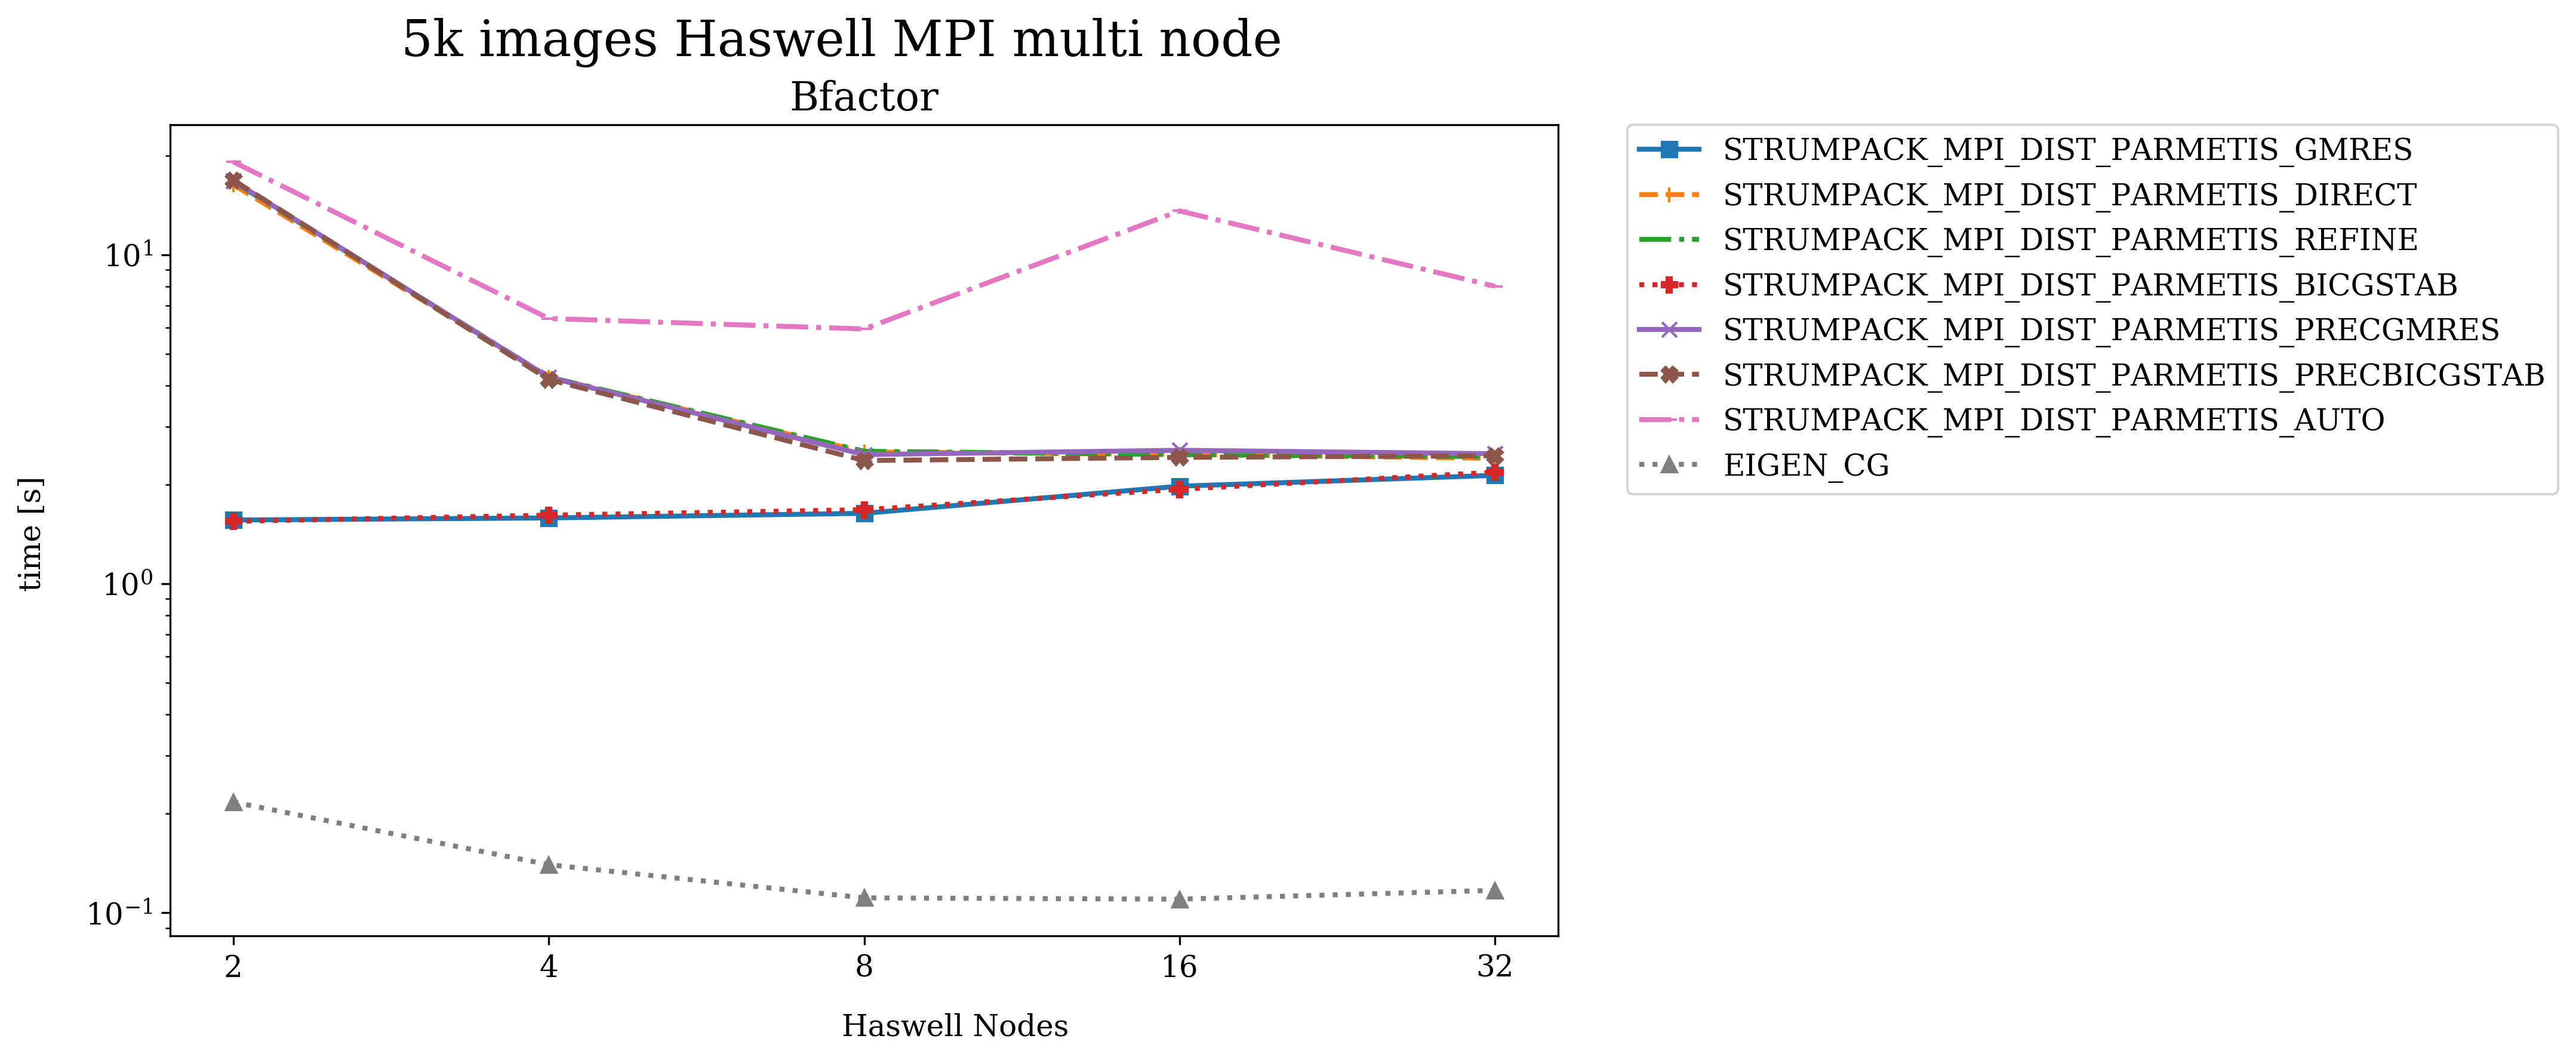

In [169]:
# define the figure size and grid layout properties
figsize = (10, 6)
cols = int(np.ceil(np.sqrt(len(params))))
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.4)
fig_hwl_mpi = plt.figure(num=1, figsize=figsize)
fig_hwl_mpi.suptitle('5k images Haswell MPI multi node', size=20)
ax = []
cbars= []
import numpy as np
i=0

from itertools import cycle
lineStyles = ["-","--","-.",":"]

for p in params:
    row = (i // cols)
    col = i % cols
    ax.append(fig_hwl_mpi.add_subplot(gs[row, col]))
    i+=1
    lineStyles_cycle = cycle(lineStyles)
    markerStyles_cycle = cycle(marker_list)
    next(markerStyles_cycle)
    for al_idx,al in enumerate(algos):

        cursor.execute('''SELECT procs, time FROM hwl_mpi_multi WHERE ref_param=? AND algo=?''',(p,al))
        np_omp_t = np.array(cursor.fetchall(),dtype=[('MPI', '<i8'), ('time', '<f8')])
        np_omp_t.sort()
        dat = zip(*np_omp_t)

        cset = ax[-1].plot(dat[0], dat[1], label=al.split("_RANK=0")[0], linewidth=2, 
                           linestyle=next(lineStyles_cycle), marker=next(markerStyles_cycle) )
        
    ax[-1].set_title(p.replace('levmar.parameter_flags=','').replace('strum_5k_omp1_params',''), size=16 )
    plt.xscale('log',basex=2)
    plt.yscale('log',basey=10)
    plt.xticks([2**n for n in xrange(6,11)],[str(2**ii) for ii in xrange(1,6)])

#gs.tight_layout(fig_hwl_omp,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
fig_hwl_mpi.text(0.04, 0.5, 'time [s]', va='center', rotation='vertical')
fig_hwl_mpi.text(0.5, 0.04, 'Haswell Nodes', va='center', rotation='horizontal')

plt.savefig('mpi_5kframes_allsolvers_hwl_mpi_multi_bfactor.pdf',)

## 32k images in data set

In [171]:
str_out={}
import os
node_list = [1,2,4,8]
sub_scripts = []

for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "32k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        if len(sub_scripts)>0:
            continue
        A_path = A_LIST[imgs_idx]; b_path = B_LIST[imgs_idx]
        dat_name = A_path.split('/')[-1][2:-4]

        print "Data Set Name:=%s"%(dat_name)

        #Ensure the A and b data are matched correctly
        assert(os.path.dirname(A_path) == os.path.dirname(b_path))
        for NODES in node_list:
            SUBMIT = SBATCH_SCRIPT_MPI_MULTI_HWL.replace('<DATA_A>',A_path)\
               .replace('<DATA_B>', b_path).replace('<DATNAME>', dat_name).replace('<NODES>', str(NODES))
            SBATCH_SCRIPT_FILE = open("SBATCH_SCRIPT_MPI_MULTI_%s.sh"%(dat_name), "w")
            sub_scripts.append("SBATCH_SCRIPT_MPI_MULTI_%s.sh"%(dat_name))
            SBATCH_SCRIPT_FILE.write(SUBMIT)
            SBATCH_SCRIPT_FILE.close()
            var = !sbatch {sub_scripts[-1]}
            print var

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Skipping 5k
Data Set Size:=32k
Data Set Name:=strum_32k_omp1_paramslevmar.parameter_flags=Eta-
['Submitted batch job 11797392']
['Submitted batch job 11797395']
['Submitted batch job 11797398']
['Submitted batch job 11797401']


In [172]:
dat_list_hwl_mpi_multi_parmetis_32k = {}
nodes_list = [1,2,4,8,16,32]
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "32k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        for NODES in nodes_list:
            MPI=32*NODES
            dat = A_LIST[imgs_idx].split('/')[-1][2:-4]
            var = !find ./MPI_MULTI_HWL -iname '{dat}_hwl_out_MPI_MULTI{MPI}_OMP1.log' #!ls OMP_KNL/{dat}_knl_out_OMP/ | grep 'log'
            if len(var)!=0:
                dat_list_hwl_mpi_multi_parmetis_32k.update({dat + str(MPI) : var})
print dat_list_hwl_mpi_multi_parmetis_32k

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Skipping 1k
Data Set Size:=5k
Skipping 5k
Data Set Size:=32k
{'strum_32k_omp1_paramslevmar.parameter_flags=Eta-32': ['./MPI_MULTI_HWL/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI32_OMP1.log'], 'strum_32k_omp1_paramslevmar.parameter_flags=Eta-64': ['./MPI_MULTI_HWL/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI64_OMP1.log'], 'strum_32k_omp1_paramslevmar.parameter_flags=Eta-256': ['./MPI_MULTI_HWL/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI256_OMP1.log'], 'strum_32k_omp1_paramslevmar.parameter_flags=Eta-128': ['./MPI_MULTI_HWL/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI/strum_32k_omp1_paramslevmar.parameter_flags=Eta-_hwl_out_MPI_MULTI128_OMP1.log']}


In [177]:
time_data_hwl_mpi_multi_parmetis_32k = {}
for key, value in dat_list_hwl_mpi_multi_parmetis_32k.iteritems():
    try:
        with open(str(value[0])) as f:
            lines = f.read().splitlines()
            zlist = {}

            [zlist.update({l.split()[-7][:-1]:float(l.split()[-3][:-2])})\
              for l in lines if "#calls" in l if any( x in l for x in ["EIGEN_CG","RANK=0"]) ]
            time_data_hwl_mpi_multi_parmetis_32k.update({key : zlist})
    except Exception as e:
        #pass
        print "Could not find key:=%s; val:=%s %s"%(key,value,e)
print time_data_hwl_mpi_multi_parmetis_32k

{'strum_32k_omp1_paramslevmar.parameter_flags=Eta-32': {}, 'strum_32k_omp1_paramslevmar.parameter_flags=Eta-64': {'STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0': 7.985, 'STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0': 529.119, 'STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=0': 527.819, 'STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0': 7.539, 'STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=0': 528.022, 'STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=0': 524.183, 'STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=0': 529.64, 'EIGEN_CG': 0.349}, 'strum_32k_omp1_paramslevmar.parameter_flags=Eta-128': {'STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0': 7.858, 'STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0': 163.248, 'STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=0': 162.918, 'STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0': 7.69, 'STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=0': 163.758, 'STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=0': 162.985, 'STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=0': 162.717, 'EIGEN_CG': 0.336}, 'strum_32k_omp1_paramslevmar

In [178]:
#DB method
import sqlite3
conn.close()
conn_parmetis_32k = sqlite3.connect(':memory:')
# Get a cursor object
cursor = conn_parmetis_32k.cursor()
cursor.execute('''
    CREATE TABLE hwl_mpi_multi_32k(id INTEGER PRIMARY KEY, ref_param TEXT,
                       procs INTEGER, algo TEXT, time REAL)
''')
for k,v in time_data_hwl_mpi_multi_parmetis_32k.iteritems():
    k_par_t = k.split('-')
    for kk,vv in v.iteritems():
        cursor.execute('''INSERT INTO hwl_mpi_multi_32k(ref_param, procs, algo, time)
                  VALUES(?,?,?,?)''', ("-".join(k_par_t[:-1]), k_par_t[-1], kk, vv))
        print "-".join(k_par_t[:-1]), k_par_t[-1], kk, vv
conn_parmetis_32k.commit()

strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0 7.985
strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0 529.119
strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 STRUMPACK_MPI_DIST_PARMETIS_REFINE_RANK=0 527.819
strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 STRUMPACK_MPI_DIST_PARMETIS_BICGSTAB_RANK=0 7.539
strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 STRUMPACK_MPI_DIST_PARMETIS_PRECGMRES_RANK=0 528.022
strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 STRUMPACK_MPI_DIST_PARMETIS_PRECBICGSTAB_RANK=0 524.183
strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 STRUMPACK_MPI_DIST_PARMETIS_AUTO_RANK=0 529.64
strum_32k_omp1_paramslevmar.parameter_flags=Eta 64 EIGEN_CG 0.349
strum_32k_omp1_paramslevmar.parameter_flags=Eta 128 STRUMPACK_MPI_DIST_PARMETIS_GMRES_RANK=0 7.858
strum_32k_omp1_paramslevmar.parameter_flags=Eta 128 STRUMPACK_MPI_DIST_PARMETIS_DIRECT_RANK=0 163.248
strum_32k_omp1_paramsle

In [180]:
cursor.execute('''SELECT DISTINCT ref_param FROM hwl_mpi_multi_32k ''')
params = [s[0] for s in cursor.fetchall()]
cursor.execute('''SELECT DISTINCT algo FROM hwl_mpi_multi_32k ''')
algos = [s[0] for s in cursor.fetchall()]

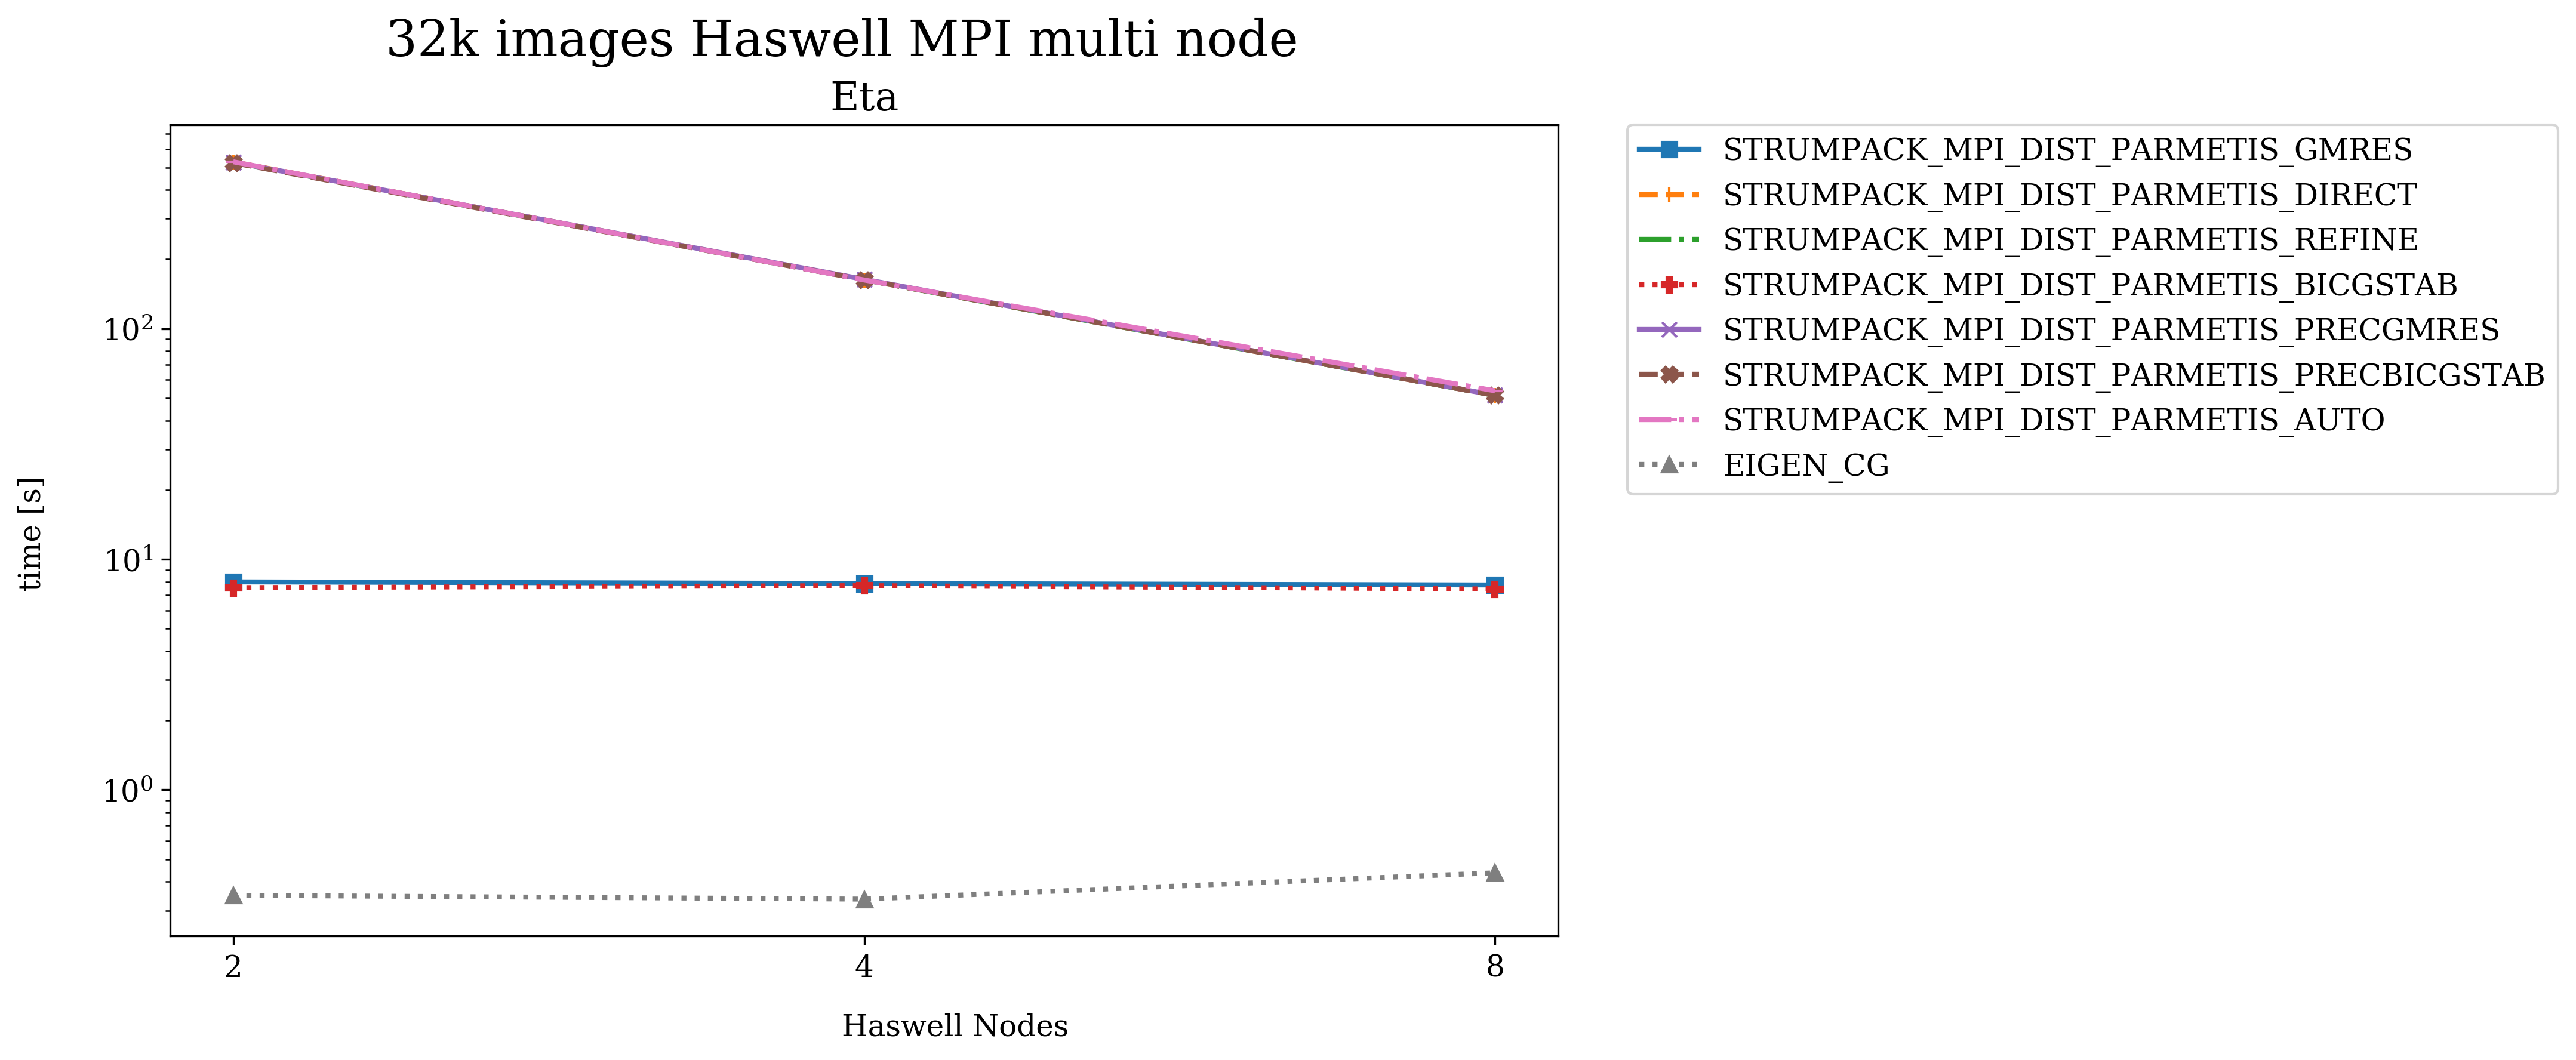

In [200]:
# define the figure size and grid layout properties
figsize = (10, 6)
cols = int(np.ceil(np.sqrt(len(params))))
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.4)
fig_hwl_mpi_32k = plt.figure(num=1, figsize=figsize)
fig_hwl_mpi_32k.suptitle('32k images Haswell MPI multi node', size=20)
ax = []
cbars= []
import numpy as np
i=0

from itertools import cycle
lineStyles = ["-","--","-.",":"]

for p in params:
    row = (i // cols)
    col = i % cols
    ax.append(fig_hwl_mpi_32k.add_subplot(gs[row, col]))
    i+=1
    lineStyles_cycle = cycle(lineStyles)
    markerStyles_cycle = cycle(marker_list)
    next(markerStyles_cycle)
    for al_idx,al in enumerate(algos):

        cursor.execute('''SELECT procs, time FROM hwl_mpi_multi_32k WHERE ref_param=? AND algo=?''',(p,al))
        np_omp_t = np.array(cursor.fetchall(),dtype=[('MPI', '<i8'), ('time', '<f8')])
        np_omp_t.sort()
        dat = zip(*np_omp_t)
        
        ax[-1].plot(dat[0], dat[1], label=al.split("_RANK=0")[0], linewidth=2, 
                           linestyle=next(lineStyles_cycle), marker=next(markerStyles_cycle) )
        
    ax[-1].set_title(p.replace('levmar.parameter_flags=','').replace('strum_32k_omp1_params',''), size=16 )
    plt.xscale('log',basex=2)
    plt.yscale('log',basey=10)
    plt.xticks([2**n for n in xrange(6,9)],[str(2**ii) for ii in xrange(1,4)])

#gs.tight_layout(fig_hwl_omp,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
fig_hwl_mpi_32k.text(0.04, 0.5, 'time [s]', va='center', rotation='vertical')
fig_hwl_mpi_32k.text(0.5, 0.04, 'Haswell Nodes', va='center', rotation='horizontal')

plt.savefig('mpi_32kframes_allsolvers_hwl_mpi_multi_bfactor.pdf',)